# Potential Evapotranspiration

In [1]:
import numpy as np
import pandas as pd
import datetime, pyeto
from neupy import algorithms, estimators
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from operator import itemgetter
# import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
import csv
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Calculation of the &#197;ngstrom-Prescott equation 

This equation will be used to calculate the solar radiation values necessary for the calculation of the Hargreaves equation below.

\begin{equation}
    H_i = H_{0i}\left(a+b\left(\frac{s_i}{s_{0i}}\right)\right)
    \label{eq:AP}
\end{equation}

where $H_i$ is the monthly solar radiationin $MJ~m^{-2}day^{-1}$, $s_i$ is the total monthly sunlight in hours.

$H_{0i}$ \& $s_{0i}$ are defined as follows:

\begin{equation}
    H_{0i} = \frac{24I_{sc}}{\pi}\left(1+0.033\cos\left(\frac{360(i)}{365}\right)\right)\left(\cos(\phi)\cos(\delta_i)\sin(\omega_{si})+\frac{2\pi\omega_{si}}{360}\sin(\phi)\sin(\delta_i)\right)
\end{equation}

\begin{equation}
    S_{0i} = \frac{2\omega_{si}}{15}
\end{equation}

where 

\begin{equation}
    \omega_{si} = \cos^{-1}(-\tan(\phi)\tan(\delta_i))
    \label{eq:omega}
\end{equation}

and

\begin{equation}
    \delta_i = -23.45\cos\left(\frac{360}{365}(i+10)\right)
    \label{eq:delta}
\end{equation}

The coefficients $a$ \& $b$ are given by Ishola et al. (2018)

In [42]:
def solar_decl(i):
    return -23.45 * np.cos(np.radians((360/365)*(i+10)))

In [43]:
def sunset_hour_angle(ϕ, δ):
    return np.arccos(-np.tan(np.radians(ϕ))*np.tan(np.radians(δ)))

In [44]:
def max_hours(ω):
    return (2*np.degrees(ω)) / 15

In [45]:
def solar_rad(i, ϕ, δ, ω):
    I_sc = 118.108
    
    A = (24*I_sc) / np.pi
    B = 1 + 0.033 * np.cos(np.radians((360*i) / 365))
    C = np.cos(np.radians(ϕ)) * np.cos(np.radians(δ)) * np.sin(np.radians(ω))
    D = ((2*np.pi*ω) / 360) * np.sin(np.radians(ϕ)) * np.sin(np.radians(δ))
    
    return A * B * (C + D)

In [46]:
def angstrom_prescott(H_0i, a, b, s_i, s_0):
    return H_0i * (a + b * (s_i/s_0))

This value of $H_0$ is given in $MJ~m^{-2}day^{-1}$, for the final calculation of the Hargreaves equation it will need to be converrted to equivalent water evaporation over time ($mm~day^{-1}$) as follows:

\begin{equation}
    1~mm~day^{-1} = 2.45~MJ~m^{-2}day^{-1}
\end{equation}

In [47]:
def ET_rad(H_0):
    return H_0 / 2.45

### testing

In [48]:
a = np.mean([0.28, 0.27, 0.26, 0.26])
b = np.mean([8.12, 7.67, 8.48, 8.26])

ϕ = 53.306 # latitude
i = 274 # day number for 1st Oct. '21
s_i = 108.3 / 31 # avg. no. hours sunshine per day

δ_i = solar_decl(i)
ω_si = sunset_hour_angle(ϕ, δ_i)
s_0i = max_hours(ω_si)
H_0i = solar_rad(i, ϕ, δ_i, ω_si)

H_0 = angstrom_prescott(H_0i, a, b, s_i, s_0i)

R_a = ET_rad(H_0)

In [49]:
dec = u"Solar declination(\N{DEGREE SIGN}):"
print((dec + "\t" + str(np.round(δ_i, 2))).expandtabs(60))

sunset = u"Sunset hour angle(\N{DEGREE SIGN}):"
print((sunset + "\t" + str(np.round(np.degrees(ω_si), 2))).expandtabs(60))

astro = "Astronomical sunshine duration(hrs):"
print((astro + "\t" + str(np.round(s_0i, 2))).expandtabs(30))

atmos = "Atmospheric solar radiation(MJ m\u207B\u00B2 day\u207B\u00B9):"
print((atmos + "\t" + str(np.round(H_0i, 2))).expandtabs(30))

MJ = "Ground level solar radiation(MJ m\u207B\u00B2 day\u207B\u00B9):"
print((MJ + "\t" + str(np.round(H_0, 2))).expandtabs(30))

mm = "Ground level solar radiation equiv. evaporation(mm day\u207B\u00B9):"
print((mm + "\t" + str(np.round(R_a, 2))).expandtabs(30))

Solar declination(°):                                       -4.12
Sunset hour angle(°):                                       84.46
Astronomical sunshine duration(hrs):                        11.26
Atmospheric solar radiation(MJ m⁻² day⁻¹):                  12.5
Ground level solar radiation(MJ m⁻² day⁻¹):                 34.88
Ground level solar radiation equiv. evaporation(mm day⁻¹):  14.24


## Calculation of the Hargreaves equation

\begin{equation}
    ET_0 = 2.3\times10^{-3}R_a\left(\frac{T_{max}+T_{min}}{2}+17.8\right)\sqrt{T_{max}-T_{min}}
    \label{eq:harg}
\end{equation}

In [50]:
def hargreaves(R_a, T_max, T_min):
    A = (T_max+T_min) / 2 + 17.8
    return 2.3e-3 * R_a * A * np.sqrt(T_max - T_min)

### testing

In [52]:
ET_0 = hargreaves(R_a, 20.1, 2.5)
print("Evapotranspiration(mm day\u207B\u00B9):", np.round(ET_0, 2))

Evapotranspiration(mm day⁻¹): 4.0


## Calculation of the Thornthwaite Euqation

\begin{equation}
    ET_0 = 16 \left(\frac{s_i}{12}\right) \left(\frac{N}{30}\right) \left(\frac{10T_d}{I}\right)^{\alpha}
    \label{eq:thorn}
\end{equation}

Where

$ET_0$ is the estimated potential evapotranspiration ($mm/month$)

$T_d$ is the average daily temperature (degrees Celsius; if this is negative, use $0$) of the month being calculated

$N$ is the number of days in the month being calculated

$s_i$ is the average day length (hours) of the month being calculated

\begin{equation}
    \alpha = (6.75 \times 10^{-7}) I^3 - (7.71 \times 10^{-5}) I^2 + (1.792 \times 10^{-2}) I + 0.49239
\end{equation}

\begin{equation}
    I = \sum_{i=1}^{12} \left(\frac{T_{m_{i}}}{5}\right)^{1.514}
\end{equation}

is a heat index which depends on the 12 monthly mean temperatures $T_{m_{i}}$

In [12]:
def heat_index(T_m):
    I = 0
    for i in range(12):
        I += (T_m[i]/5)**1.514
    return I

In [13]:
def emp_index(I):
    A = 6.75e-7 * I**3
    B = 7.71e-5 * I**2
    C = 1.792e-2 * I
    D = 0.49239
    return A - B + C + D

In [14]:
def thornthwaite(L, N, T_d, I, α):
    return 16 * (L/12) * (N/30) * (10*T_d/I)**α

### testing

In [15]:
T_m = [8.2, 4.6, 3.8, 6.1, 7.4, 6.5, 9.5, 14.2, 17, 15.2, 15, 11.8]
L = 108.3 / 31 # avg. no. hours sunshine per day
N = 30 # no. of days

I = heat_index(T_m)
α = emp_index(I)

ET_0 = []

for T_d in T_m:
    ET_0.append(thornthwaite(L, N, T_d, I, α))

In [16]:
ET_0

[11.131523375668095,
 5.973494480776149,
 4.862789180355946,
 8.094846834173735,
 9.966679970028201,
 8.667809634763309,
 13.042769752383922,
 20.106362074023682,
 24.405819091091654,
 21.635019543629184,
 21.328653352196756,
 16.472346688552225]

## Testing the PyEto package

\* testing against the numerical method in $\S2$ & $\S3$ above.

### Hargreaves equation

In [17]:
lat = pyeto.deg2rad(53.306)  # Convert latitude to radians
day_of_year = datetime.date(2021, 10, 1).timetuple().tm_yday # day number

sol_dec = pyeto.sol_dec(day_of_year)            # Solar declination
sha = pyeto.sunset_hour_angle(lat, sol_dec)
ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
et_rad = pyeto.et_rad(lat, sol_dec, sha, ird)   # Extraterrestrial radiation

pyeto.hargreaves(2.5, 20.1, 11.8, et_rad)

2.2085747113741876

### Thornthwaite equation

In [18]:
latitude = pyeto.deg2rad(53.306)
mean_monthly_temperature = [3.8, 6.1, 7.4, 6.5, 9.5, 14.2, 17, 15.2, 15, 11.8, 0, 0]
monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight)

[12.40119158558873,
 22.012458617103142,
 36.147845788444705,
 36.328274919251754,
 63.172666740743836,
 98.46849867697085,
 118.86926541469109,
 94.81162942513981,
 77.23765278773507,
 51.37618772975233,
 0.0,
 0.0]

## Dataset 1 - Historic data from Casement Aerodrome weather station

### Casement Aerodrome - EDA

In [2]:
df_1 = pd.read_csv("../Datasets/damo/mly3723/mly3723.csv",
                   skiprows=19,
                   parse_dates= {"date" : ["year","month"]},
                   keep_date_col=True
                  )

In [3]:
!cat ../Datasets/damo/mly3723/header.txt

Station Name: CASEMENT
Station Height: 91 M 
Latitude:53.306  ,Longitude: -6.439


year:  -  Year
month: -  Month
rain:  -  Precipitation Amount (mm)
meant: -  Mean Air Temperature (C)
maxtp: -  Maximum Air Temperature (C)	  
mintp: -  Minimum  Air Temperature (C)	
mnmax: -  Mean Maximum Temperature (C)
mnmin: -  Mean Minimum Temperature (C)
gmin:  -  Grass Minimum Temperature (C)
wdsp:  -  Mean Wind Speed (knot)
mxgt:  -  Highest Gust (knot)
sun:   -  Sunshine duration (hours)
ind:   -  Indicator


In [19]:
month = ["January", "February", "March", "April",
         "May", "June", "July", "August",
         "September", "October", "November", "December"]

In [4]:
df_1.head()

date  year month  meant  maxtp  mintp  mnmax  mnmin  rain  gmin wdsp  \
0 1964-01-01  1964     1    5.5   10.9   -3.3    8.2    2.9  18.1  -7.8        
1 1964-02-01  1964     2    5.0   13.3   -6.7    7.9    2.2  22.4 -11.1        
2 1964-03-01  1964     3    5.1   13.0   -3.2    8.6    1.6  64.1  -7.4        
3 1964-04-01  1964     4    8.2   16.2   -2.4   12.2    4.2  49.5  -7.3        
4 1964-05-01  1964     5   11.7   21.3    2.9   16.2    7.2  42.8   0.4        

  maxgt    sun  
0         38.9  
1         87.7  
2         74.9  
3        148.0  
4        195.3

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    693 non-null    datetime64[ns]
 1   year    693 non-null    object        
 2   month   693 non-null    object        
 3   meant   693 non-null    float64       
 4   maxtp   693 non-null    float64       
 5   mintp   693 non-null    float64       
 6   mnmax   693 non-null    float64       
 7   mnmin   693 non-null    float64       
 8   rain    693 non-null    float64       
 9   gmin    693 non-null    float64       
 10  wdsp    693 non-null    object        
 11  maxgt   693 non-null    object        
 12  sun     693 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 70.5+ KB


\* Note here that there is no missing data. Our import date parssing has caused the year and month columns to be recast as objets however so we'll have to fix that. Windspeed and max windspeed observations are also objects but are not required for this analysis.

In [3]:
df_1.year = pd.to_numeric(df_1.year)

In [4]:
df_1.month = pd.to_numeric(df_1.month)

In [8]:
df_1.tail()

date  year  month  meant  maxtp  mintp  mnmax  mnmin  rain  gmin  \
688 2021-06-01  2021      6   14.2   24.3    3.0   18.9    9.4  17.8   0.3   
689 2021-07-01  2021      7   17.0   28.0    7.7   21.4   12.6  94.0   4.3   
690 2021-08-01  2021      8   15.2   22.7    6.6   19.1   11.3  47.3   5.0   
691 2021-09-01  2021      9   15.0   23.6    5.2   18.7   11.3  42.1   3.5   
692 2021-10-01  2021     10   11.8   20.1    2.5   14.8    8.7  77.2   0.3   

     wdsp maxgt    sun  
688   7.8    33  179.6  
689   6.1    33  199.7  
690   7.7    38  130.2  
691   7.5    38   99.3  
692  10.6    43  108.3

\* note here that we are missing the last two observation for 2021. These will be filled with the mean for the respective months except for the year and month values which will be set accordingly.

In [5]:
for i in range(2):
    df_1 = df_1.append(pd.Series(df_1[df_1.month==i+11].mean(), index=df_1.columns), ignore_index=True)
    df_1.year.iloc[-1] = 2021
    df_1.month.iloc[-1] = i + 11

In [14]:
df_1.tail() 

date    year  month      meant      maxtp     mintp      mnmax  \
690 2021-08-01  2021.0    8.0  15.200000  22.700000  6.600000  19.100000   
691 2021-09-01  2021.0    9.0  15.000000  23.600000  5.200000  18.700000   
692 2021-10-01  2021.0   10.0  11.800000  20.100000  2.500000  14.800000   
693        NaT  2021.0   11.0   6.915789  14.950877 -3.201754  10.045614   
694        NaT  2021.0   12.0   5.540351  13.221053 -4.591228   8.389474   

         mnmin       rain      gmin  wdsp  \
690  11.300000  47.300000  5.000000   7.7   
691  11.300000  42.100000  3.500000   7.5   
692   8.700000  77.200000  0.300000  10.6   
693   3.796491  74.471930 -6.691228   NaN   
694   2.707018  75.777193 -8.091228   NaN   

                                                 maxgt         sun  
690                                                 38  130.200000  
691                                                 38   99.300000  
692                                                 43  108.300000  
693  7449975909815723859257185055998886286893192975...   66.021053  
694  1132192168183396224729391847667954466611969344...   46.573684

In [6]:
df_1.date[693] = pd.to_datetime("2021-11-1")
df_1.date[694] = pd.to_datetime("2021-12-1")

In [16]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    695 non-null    datetime64[ns]
 1   year    695 non-null    float64       
 2   month   695 non-null    float64       
 3   meant   695 non-null    float64       
 4   maxtp   695 non-null    float64       
 5   mintp   695 non-null    float64       
 6   mnmax   695 non-null    float64       
 7   mnmin   695 non-null    float64       
 8   rain    695 non-null    float64       
 9   gmin    695 non-null    float64       
 10  wdsp    693 non-null    object        
 11  maxgt   695 non-null    object        
 12  sun     695 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 70.7+ KB


In [17]:
df_1.tail()

date    year  month      meant      maxtp     mintp      mnmax  \
690 2021-08-01  2021.0    8.0  15.200000  22.700000  6.600000  19.100000   
691 2021-09-01  2021.0    9.0  15.000000  23.600000  5.200000  18.700000   
692 2021-10-01  2021.0   10.0  11.800000  20.100000  2.500000  14.800000   
693 2021-11-01  2021.0   11.0   6.915789  14.950877 -3.201754  10.045614   
694 2021-12-01  2021.0   12.0   5.540351  13.221053 -4.591228   8.389474   

         mnmin       rain      gmin  wdsp  \
690  11.300000  47.300000  5.000000   7.7   
691  11.300000  42.100000  3.500000   7.5   
692   8.700000  77.200000  0.300000  10.6   
693   3.796491  74.471930 -6.691228   NaN   
694   2.707018  75.777193 -8.091228   NaN   

                                                 maxgt         sun  
690                                                 38  130.200000  
691                                                 38   99.300000  
692                                                 43  108.300000  
693  7449975909815723859257185055998886286893192975...   66.021053  
694  1132192168183396224729391847667954466611969344...   46.573684

In [18]:
len(df_1)

695

We can see another problem here. There is a missing observation somewhere. We have 695 observations which is equal to 57 years and 11 months.

In [19]:
df_1.month.value_counts()

1.0     58
2.0     58
4.0     58
5.0     58
6.0     58
7.0     58
8.0     58
9.0     58
10.0    58
11.0    58
12.0    58
3.0     57
Name: month, dtype: int64

So we can see here that we are missing an entry for March in one of the years.

In [20]:
df_1.year.value_counts()

1964.0    12
1965.0    12
1995.0    12
1996.0    12
1997.0    12
1998.0    12
1999.0    12
2000.0    12
2001.0    12
2002.0    12
2003.0    12
2004.0    12
2005.0    12
2006.0    12
2007.0    12
2008.0    12
2009.0    12
2010.0    12
2011.0    12
2012.0    12
2013.0    12
2014.0    12
2015.0    12
2016.0    12
2017.0    12
2018.0    12
2019.0    12
1994.0    12
1993.0    12
1992.0    12
1991.0    12
1966.0    12
1967.0    12
1968.0    12
1969.0    12
1970.0    12
1971.0    12
1972.0    12
1973.0    12
1974.0    12
1975.0    12
1976.0    12
1977.0    12
1978.0    12
1979.0    12
1980.0    12
1981.0    12
1982.0    12
1983.0    12
1984.0    12
1985.0    12
1986.0    12
1987.0    12
1988.0    12
1989.0    12
1990.0    12
2021.0    12
2020.0    11
Name: year, dtype: int64

So 2020 is missing its March observation. This will be temporarily filled with 0 in the same manner as the November and December observations of 2021.

In [7]:
df_1.loc[df_1.year == 2020]

date    year  month  meant  maxtp  mintp  mnmax  mnmin   rain  gmin  \
672 2020-01-01  2020.0    1.0    6.1   13.6   -3.7    8.8    3.4   49.3  -8.2   
673 2020-02-01  2020.0    2.0    5.6   12.9   -1.3    8.8    2.3  155.4  -6.1   
674 2020-04-01  2020.0    4.0    9.4   20.1   -2.1   13.8    5.0   19.3  -6.9   
675 2020-05-01  2020.0    5.0   12.1   25.7   -2.5   17.3    6.8   10.7  -6.7   
676 2020-06-01  2020.0    6.0   13.5   25.4    2.8   17.6    9.4   87.0  -0.4   
677 2020-07-01  2020.0    7.0   14.6   22.9    5.1   18.2   10.9  114.4   1.7   
678 2020-08-01  2020.0    8.0   15.1   24.3    3.5   18.8   11.4   85.1   0.8   
679 2020-09-01  2020.0    9.0   13.0   23.1   -0.7   17.2    8.7   48.1  -3.1   
680 2020-10-01  2020.0   10.0    9.4   15.9    1.6   12.6    6.2   81.7  -2.2   
681 2020-11-01  2020.0   11.0    8.2   16.3   -0.9   11.3    5.1   58.6  -6.6   
682 2020-12-01  2020.0   12.0    4.6   12.9   -4.3    7.3    2.0   77.9  -7.4   

     wdsp maxgt    sun  
672  13.0    60   65.6  
673  16.3    61   83.6  
674   7.7    40  187.9  
675   8.5    52  294.8  
676   8.7    42  126.5  
677   9.3    44  129.2  
678   8.4    53  105.3  
679   9.3    36  144.8  
680  11.1    50  103.4  
681  11.7    49   73.0  
682  10.9    50   53.8

In [8]:
march = ["2020-3-1", 2020, 3, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

new_df = pd.DataFrame([march], columns=df_1.columns)

df_1 = pd.concat([df_1.iloc[:674], new_df, df_1.iloc[674:]], ignore_index = True)
df_1.date = pd.to_datetime(df_1.date)

In [9]:
# imputing values for meant, mintp, maxtp, sun
df_1.meant.interpolate(method='polynomial', order=2, inplace=True)
df_1.mintp.interpolate(method='polynomial', order=2, inplace=True)
df_1.maxtp.interpolate(method='polynomial', order=2, inplace=True)
df_1.sun.interpolate(method='polynomial', order=2, inplace=True)

In [10]:
# checking the imputation
df_1.meant.iloc[672:676]

672    6.100000
673    5.600000
674    6.856726
675    9.400000
Name: meant, dtype: float64

In [25]:
len(df_1)

696

In [26]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    696 non-null    datetime64[ns]
 1   year    696 non-null    float64       
 2   month   696 non-null    float64       
 3   meant   696 non-null    float64       
 4   maxtp   696 non-null    float64       
 5   mintp   696 non-null    float64       
 6   mnmax   695 non-null    float64       
 7   mnmin   695 non-null    float64       
 8   rain    695 non-null    float64       
 9   gmin    695 non-null    float64       
 10  wdsp    693 non-null    object        
 11  maxgt   695 non-null    object        
 12  sun     696 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 70.8+ KB


In [11]:
# need to convert year and month to int64 for indexing
df_1 = df_1.astype({'year': 'int64', 'month': 'int64'})

In [28]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    696 non-null    datetime64[ns]
 1   year    696 non-null    int64         
 2   month   696 non-null    int64         
 3   meant   696 non-null    float64       
 4   maxtp   696 non-null    float64       
 5   mintp   696 non-null    float64       
 6   mnmax   695 non-null    float64       
 7   mnmin   695 non-null    float64       
 8   rain    695 non-null    float64       
 9   gmin    695 non-null    float64       
 10  wdsp    693 non-null    object        
 11  maxgt   695 non-null    object        
 12  sun     696 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 70.8+ KB


In [29]:
df_1.loc[df_1.year == 2020]

date  year  month      meant     maxtp     mintp  mnmax  mnmin  \
672 2020-01-01  2020      1   6.100000  13.60000 -3.700000    8.8    3.4   
673 2020-02-01  2020      2   5.600000  12.90000 -1.300000    8.8    2.3   
674 2020-03-01  2020      3   6.856726  15.13171 -0.856121    NaN    NaN   
675 2020-04-01  2020      4   9.400000  20.10000 -2.100000   13.8    5.0   
676 2020-05-01  2020      5  12.100000  25.70000 -2.500000   17.3    6.8   
677 2020-06-01  2020      6  13.500000  25.40000  2.800000   17.6    9.4   
678 2020-07-01  2020      7  14.600000  22.90000  5.100000   18.2   10.9   
679 2020-08-01  2020      8  15.100000  24.30000  3.500000   18.8   11.4   
680 2020-09-01  2020      9  13.000000  23.10000 -0.700000   17.2    8.7   
681 2020-10-01  2020     10   9.400000  15.90000  1.600000   12.6    6.2   
682 2020-11-01  2020     11   8.200000  16.30000 -0.900000   11.3    5.1   
683 2020-12-01  2020     12   4.600000  12.90000 -4.300000    7.3    2.0   

      rain  gmin  wdsp maxgt        sun  
672   49.3  -8.2  13.0    60   65.60000  
673  155.4  -6.1  16.3    61   83.60000  
674    NaN   NaN   NaN   NaN  110.02978  
675   19.3  -6.9   7.7    40  187.90000  
676   10.7  -6.7   8.5    52  294.80000  
677   87.0  -0.4   8.7    42  126.50000  
678  114.4   1.7   9.3    44  129.20000  
679   85.1   0.8   8.4    53  105.30000  
680   48.1  -3.1   9.3    36  144.80000  
681   81.7  -2.2  11.1    50  103.40000  
682   58.6  -6.6  11.7    49   73.00000  
683   77.9  -7.4  10.9    50   53.80000

In [129]:
scaler = MinMaxScaler()
df_1_scaled = scaler.fit_transform(df_1[["meant", "mintp", "maxtp", "sun"]])
ax = sns.boxplot(data=df_1_scaled)
sns.swarmplot(data=df_1_scaled, color='k', size=2)

plt.title("Casement Aeordrome")
xticks = ["Mean Temp", "Min Temp", "Max Temp", "Sun Hrs"]
ax.set_xticklabels(xticks)
plt.xlabel("")

Text(0.5, 0, '')

In [76]:
df_1[["meant", "maxtp", "mintp", "sun"]].describe().to_csv("CA_descriptive.csv")

### Casement Aerodrome - Testing - Mean Temperature.

The data we need here is just the mean temperature values. We can use a pivot to transform the attribute into a dataframe of its own with each row being a year and each column being a month.

In [85]:
CA_meant = df_1.pivot(index="year", columns="month", values="meant")
CA_meant.head()

month   1    2    3    4     5     6     7     8     9     10   11   12
year                                                                   
1964   5.5  5.0  5.1  8.2  11.7  12.8  14.9  14.1  13.2   8.7  7.2  4.4
1965   3.3  3.2  6.0  8.0  10.8  13.3  12.7  14.0  11.3  10.9  4.8  4.9
1966   4.5  6.3  6.8  7.0  10.4  14.2  13.9  13.8  13.3   8.7  5.1  5.9
1967   5.3  5.3  6.5  8.2   8.8  13.4  15.4  14.2  12.5   9.5  5.6  4.9
1968   5.5  2.6  6.1  7.1   8.8  13.5  13.8  14.5  13.2  12.0  7.4  4.6

In [86]:
CA_meant.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='month')

Let's have a look at one of the months and see what we're dealing with.

Text(0, 0.5, 'Mean Temp. ($^{\\circ}C$)')

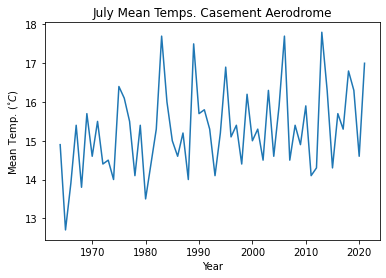

In [87]:
plt.plot(CA_meant.index, CA_meant[7])
plt.title("July Mean Temps. Casement Aerodrome")
plt.xlabel("Year")
plt.ylabel(r"Mean Temp. ($^{\circ}C$)")

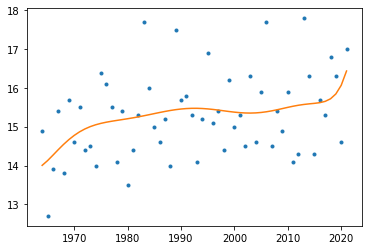

In [88]:
# let's try to find te best fitting fumction for the data above

p30 = np.poly1d(np.polyfit(CA_meant.index, CA_meant[7], 93))

plt.plot(CA_meant.index, CA_meant[7], '.')
plt.plot(CA_meant.index, p30(CA_meant.index))

This hasn't produced the best results. Next let's try feeding it into the GRNN to see if that can do any better.

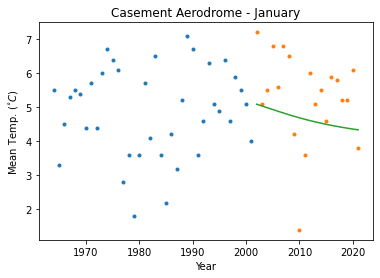

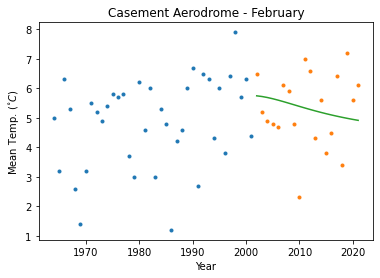

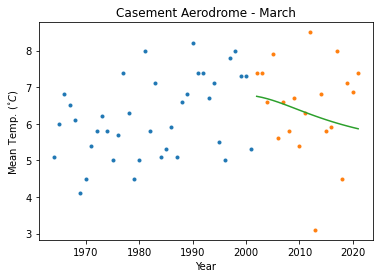

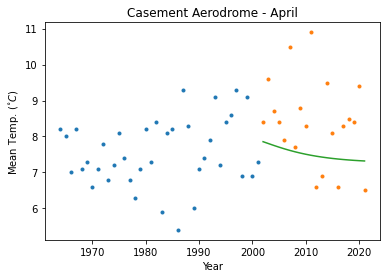

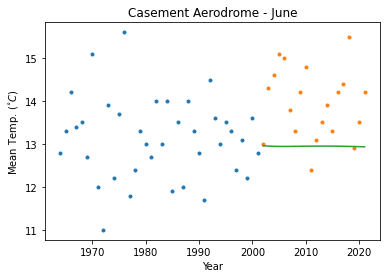

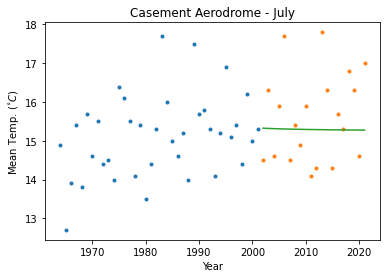

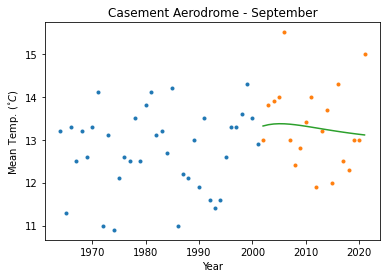

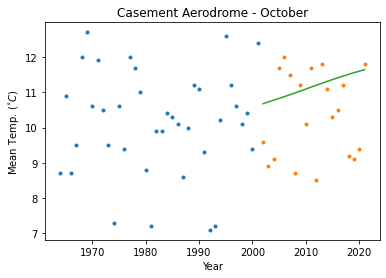

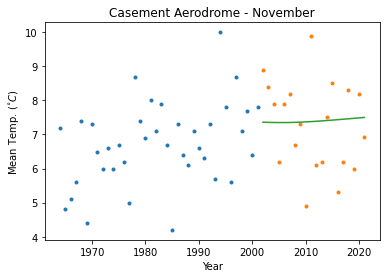

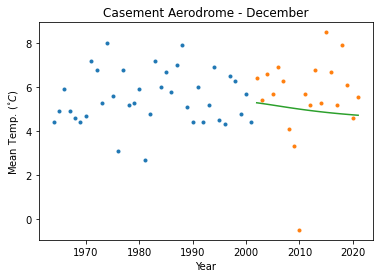

In [90]:
# TESTING FOR TEMP PREDICTIONS!!!!!
X_std = MinMaxScaler().fit_transform(CA_meant.index.values.reshape(-1, 1))

X_train = X_std[:38]
X_test = X_std[38:]

y_test = []
y_train = []

y_pred = []
mse = []
mse_sc = []

scaler = MinMaxScaler()

for col in CA_meant.columns:
    # manual splitting
    y = scaler.fit_transform(np.array(CA_meant[col]).reshape(-1, 1))
    y_train.append(y[:38])
    y_test.append(y[38:])

    nw = algorithms.GRNN(std=0.1, verbose=False)
    nw.train(X_train, y_train[col-1])

    y_pred.append(nw.predict(X_test))
    mse.append(np.mean((y_pred[col-1] - y_test[col-1]) ** 2))
    
    mse_sc.append(np.mean(
        scaler.inverse_transform(y_pred[col-1]) - scaler.inverse_transform(y_test[col-1])
        ) ** 2)
    
    plt.plot(CA_meant.index.values[:38], 
             scaler.inverse_transform(y_train[col-1]), 
             '.', label="Training Data")
    plt.plot(CA_meant.index.values[38:], 
             scaler.inverse_transform(y_test[col-1]), 
             '.', label="Testing Data")
    plt.plot(CA_meant.index.values[38:], 
             scaler.inverse_transform(y_pred[col-1]), 
             label="Prediction")
    
    plt.title("Casement Aerodrome - " + month[col-1])
    plt.xlabel("Year")
    plt.ylabel(r"Mean Temp. ($^{\circ}C$)")
    plt.show()

In [91]:
mse

[0.058641332684952176,
 0.03595926099167016,
 0.05298991147105431,
 0.06955829068343737,
 0.04050802790869302,
 0.07818114620853474,
 0.05208909626809231,
 0.01459165621399457,
 0.04003073519207064,
 0.06698107158995392,
 0.04920003971483336,
 0.04673562661345766]

In [92]:
mse_sc

[0.4025474130566389,
 0.0014127025527482465,
 0.03316418480301264,
 0.7919966478275986,
 0.060087602625687,
 1.0073124750478981,
 0.10071322871303989,
 0.0009688462933736052,
 0.005012922942101408,
 0.6354081427505277,
 0.01550814241553439,
 0.3761418688689651]

In [93]:
np.sqrt(mse_sc)

array([0.63446624, 0.03758594, 0.18211036, 0.88994194, 0.24512773,
       1.00364958, 0.31735348, 0.0311263 , 0.070802  , 0.79712492,
       0.12453169, 0.61330406])

As we can see from the plots, this isn't much of an improvement either. Despite the poor fit the error values are quite low. This probably means there is some mistake in that calculation and for the final analysis I will probably replace it with an automated version such as the `neupy.estimators.rmse()` function.

Let's try the standard linear regression. Given the nature of the data it is unlikely to provide  good fit but we'll have a look anyway.

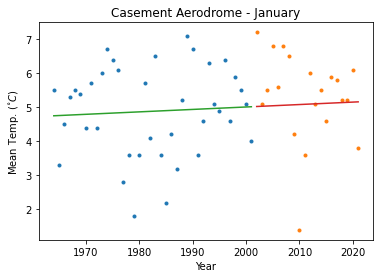

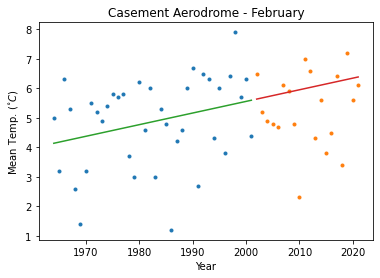

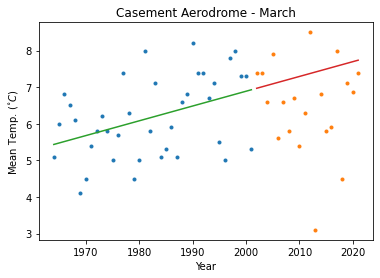

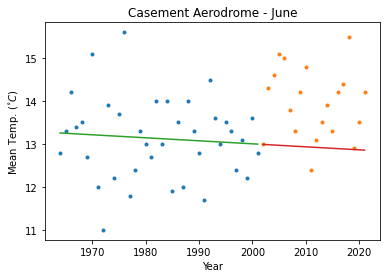

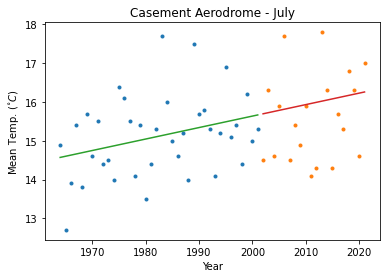

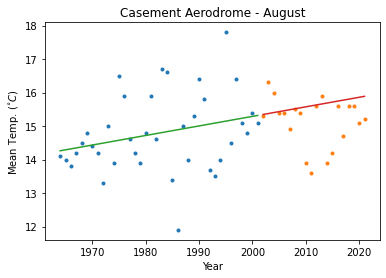

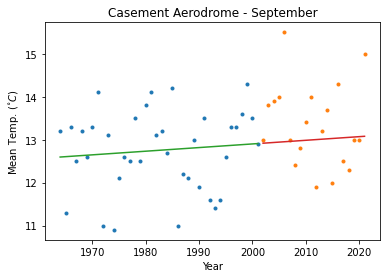

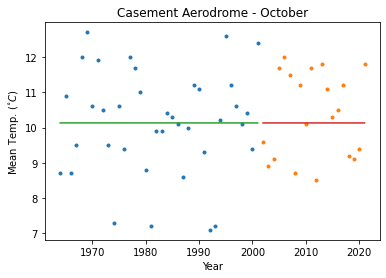

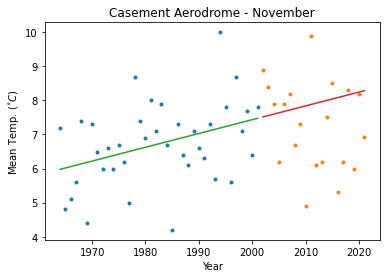

In [94]:
# TIME SERIES ANALYSIS

X_train = CA_meant.index.values[:38]
X_test = CA_meant.index.values[38:]

y_test = []
y_train = []

y_pred = []
y_pred_train = []
mse = []
r2 = []

regressor = LinearRegression()

for col in CA_meant.columns:
    # manual splitting
    y_train.append(CA_meant[col][:38])
    y_test.append(CA_meant[col][38:])

    regressor.fit(np.array(X_train).reshape(-1,1), y_train[col-1])

    y_pred.append(regressor.predict(np.array(X_test).reshape(-1,1)))
    y_pred_train.append(regressor.predict(np.array(X_train).reshape(-1,1)))
    mse.append(np.mean((y_pred[col-1] - np.array(y_test[col-1])) ** 2))
    
    r2.append(r2_score(np.array(y_test[col-1]).reshape(-1,1), y_pred[col-1]))
    
    plt.plot(CA_meant.index.values[:38], y_train[col-1], '.', label="Training Data")
    plt.plot(CA_meant.index.values[38:], y_test[col-1], '.', label="Testing Data")
    plt.plot(CA_meant.index.values[:38], y_pred_train[col-1], label="Prediction")
    plt.plot(CA_meant.index.values[38:], y_pred[col-1], label="Prediction")
    
    plt.title("Casement Aerodrome - " + month[col-1])
    plt.xlabel("Year")
    plt.ylabel(r"Mean Temp. ($^{\circ}C$)")
    plt.show()

In [95]:
r2

[-0.04153980942098401,
 -0.3624399260850599,
 -0.5767165787009612,
 -0.1422086496962791,
 -0.044801799534854636,
 -1.6280903799833317,
 -0.07760774886187316,
 -0.5566538324857202,
 -0.15126620619943432,
 -0.04062357222659441,
 -0.36657570271901174,
 0.0008673570203719949]

As expected this was not great.

Now let's try something different. Time series analysis with Autoregressive Moving Average (ARMA). This model is provided by the `statsmodels` package and should hopefully perform a bit better than the methods used above.

In [96]:
# TIME SERIES ANALYSIS W/ ARMA

X_train = CA_meant.index.values[:38]
X_test = CA_meant.index.values[38:]

y_test = CA_meant[1][38:]
y_train = CA_meant[1][:38]

y_pred = []
y_pred_train = []
mse = []
r2 = []

ARMAmodel = SARIMAX(y_train, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test
y_pred_out = y_pred_df["Predictions"] 
    
plt.plot(CA_meant.index.values[:38], y_train, '.', label="Training Data")
plt.plot(CA_meant.index.values[38:], y_test, '.', label="Testing Data")
# plt.plot(CA_meant.index.values[:38], y_pred_train[col-1], label="Prediction")
plt.plot(CA_meant.index.values[38:], y_pred_out, label="Prediction")
    
plt.title("Casement Aerodrome - " + month[col-1])
plt.xlabel("Year")
plt.ylabel(r"Mean Temp. ($^{\circ}C$)")
plt.show()

This is very similar to the linear regression model.

In [97]:
arma_rmse = np.sqrt(mean_squared_error(X_test, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  2006.6357644905652


The huge error here confirms the badness of the fit.

Let's try another model from `statsmodels` which is more capable of handling non stationary time series. Autoregressive Integrated Moving Average (ARIMA).

In [98]:
ARIMAmodel = ARIMA(y_train, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test
y_pred_out = y_pred_df["Predictions"] 

plt.plot(CA_meant.index.values[:38], y_train, '.', label="Training Data")
plt.plot(CA_meant.index.values[38:], y_test, '.', label="Testing Data")
# plt.plot(CA_meant.index.values[:38], y_pred_train[col-1], label="Prediction")
plt.plot(CA_meant.index.values[38:], y_pred_out, label="Prediction")
    
plt.title("Casement Aerodrome - " + month[col-1])
plt.xlabel("Year")
plt.ylabel(r"Mean Temp. ($^{\circ}C$)")
plt.show()

In [99]:
arma_rmse = np.sqrt(mean_squared_error(X_test, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  2007.6199522966585


The error is still very large here but the plot of the predicted values does at least show some movement which is promising. This might possibly be improved by tweaking the hyper parameters.

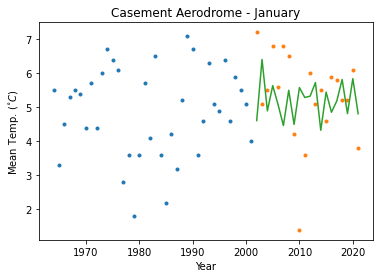

RMSE:  1.471119732958339


In [100]:
ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test
y_pred_out = y_pred_df["Predictions"] 

plt.plot(CA_meant.index.values[:38], y_train, '.', label="Training Data")
plt.plot(CA_meant.index.values[38:], y_test, '.', label="Testing Data")
# plt.plot(CA_meant.index.values[:38], y_pred_train[col-1], label="Prediction")
plt.plot(CA_meant.index.values[38:], y_pred_out, label="Prediction")
    
plt.title("Casement Aerodrome - January")
plt.xlabel("Year")
plt.ylabel(r"Mean Temp. ($^{\circ}C$)")
plt.show()

arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

This is much better. Let's have a look at the first few tentative predictions and see if they are reasonable. 

In [101]:
X_pred = np.array([2022, 2023])

In [102]:
y_pred = ARIMAmodel.get_forecast(len(X_pred))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
print(y_pred_df["Predictions"])

38    4.608222
39    6.401207
Name: Predictions, dtype: float64


4 \& 6 $^{\circ}$C seem like reasonable estimations of the mean temperature for January.

In [104]:
residuals = pd.DataFrame(ARIMAmodel.resid)
residuals.plot(legend=None)
plt.title("Casement Aerodrome - January")

Text(0.5, 1.0, 'Casement Aerodrome - January')

Great! Now we just need to repeat that for each month using a simple `for` loop. Then we do the same again for the other observations required. Then we repeat the entire thing for each of the remaining weather station locations. There's no need to produce plots for each of these as this will result in the 12 x 4 x 4 = 192 plots. It will suffice to show one for each observation, possibly from each location and simply print the error instead as this will give an indication if anything has gone wrong in the loop.

### Casement Aerodrome - Mean Temperature

In [105]:
# TIME SERIES ANALYSIS

# X_train = CA_meant.index.values[:38]
X_test = CA_meant.index.values[38:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in CA_meant.columns:
    # manual splitting
    y_train = CA_meant[col][:38]
    y_test = CA_meant[col][38:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.471 [4.60822214 6.40120673 4.89240814 5.63411644]
February  RMSE:  1.661 [5.1731208  6.59152974 4.473308   5.6633287 ]
March  RMSE:  24.972 [ 3.30000119  1.30000275 -0.69999488 -2.69999243]
April  RMSE:  4.222 [7.69996465 8.09990339 8.49987213 8.899837  ]
May  RMSE:  6.423 [11.99999264 12.49998621 12.99998005 13.49997584]
June  RMSE:  10.601 [12.00000367 11.20000983 10.40001666  9.60001786]
July  RMSE:  3.41 [15.5999866  15.8999823  16.19996745 16.49996428]
August  RMSE:  3.64 [14.79999543 14.49999319 14.19998625 13.89998499]
September  RMSE:  7.562 [12.29999305 11.69999389 11.09998659 10.49998107]
October  RMSE:  2.821 [11.47031851  9.91179092  9.48838336 11.92920312]
November  RMSE:  2.045 [8.62833029 7.94114117 5.66005352 9.5116319 ]
December  RMSE:  16.797 [ 3.10001043  1.80002372  0.50002721 -0.79996303]


### Casement Aerodrome - Minimum Temperature

In [106]:
CA_mintp = df_1.pivot(index="year", columns="month", values="mintp")
CA_mintp.head()

month   1    2    3    4    5    6    7    8    9    10   11   12
year                                                             
1964  -3.3 -6.7 -3.2 -2.4  2.9  2.9  3.6  1.5  1.9 -0.9 -6.7 -5.2
1965  -4.8 -7.1 -9.6 -1.8 -1.7  0.7  3.1  4.4  2.2  0.4 -5.1 -5.8
1966  -4.8  0.6 -3.0 -4.0  1.6  6.1  5.1  3.4  3.5  0.3 -3.2 -2.9
1967  -3.9 -2.6 -2.1  0.3 -2.0  3.8  6.4  4.7  3.2  0.0 -4.1 -5.6
1968  -3.2 -6.1 -3.7 -4.4 -1.3  3.9  5.5  6.3  4.1  1.8 -4.0 -4.6

In [107]:
# TIME SERIES ANALYSIS

X_test = CA_mintp.index.values[38:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in CA_mintp.columns:
    # manual splitting
    y_train = CA_mintp[col][:38]
    y_test = CA_mintp[col][38:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (7, 2, 6))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arima_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  3.084 [-1.62178229 -1.51434039 -5.27342085 -3.22790812]
February  RMSE:  2.129 [-3.5679593  -4.20001152 -2.95264378 -2.69653883]
March  RMSE:  2.097 [-3.2434132  -1.45052509 -1.53005672 -3.41700391]
April  RMSE:  1.572 [-1.45754213 -2.73902147 -2.18425815 -2.23016309]
May  RMSE:  2.647 [ 0.99365698 -1.25743248  0.68180567  0.75790408]
June  RMSE:  1.526 [4.09541431 3.68417803 3.97619484 0.44315618]
July  RMSE:  1.53 [7.05687137 6.14189925 6.69309427 7.36004529]
August  RMSE:  1.584 [5.65405434 5.01729984 6.25254355 5.17294957]
September  RMSE:  2.481 [4.20796011 1.55530687 3.38379809 2.13958102]
October  RMSE:  2.086 [ 0.09988716 -0.12036242 -1.00295763  0.62714031]
November  RMSE:  2.476 [-2.03463159 -1.83051236 -2.40844996 -2.10310665]
December  RMSE:  4.051 [-3.59280639 -6.14905258 -6.11651621 -5.59937131]


### Casement Aerodrome - Maximum Temperature

In [108]:
CA_maxtp = df_1.pivot(index="year", columns="month", values="maxtp")
CA_maxtp.head()

month    1     2     3     4     5     6     7     8     9     10    11    12
year                                                                         
1964   10.9  13.3  13.0  16.2  21.3  22.9  23.3  23.1  21.6  17.3  14.6  12.6
1965   11.9   9.9  21.0  15.8  24.2  21.8  19.5  22.0  20.3  18.4  13.8  13.4
1966   11.7  12.6  13.4  19.5  22.6  22.4  23.3  22.0  21.1  16.8  11.9  12.2
1967   12.4  12.3  15.7  19.5  18.5  23.1  22.7  21.6  19.3  17.6  12.6  13.5
1968   13.1  10.1  18.8  15.8  21.3  23.0  23.5  23.8  22.4  18.8  14.3  13.2

In [109]:
# TIME SERIES ANALYSIS

X_test = CA_maxtp.index.values[38:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in CA_maxtp.columns:
    # manual splitting
    y_train = CA_maxtp[col][:38]
    y_test = CA_maxtp[col][38:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (7, 2, 6))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arima_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.331 [11.00134926 12.5917663  12.93395836 13.97226542]
February  RMSE:  1.465 [12.41379112 12.13571668 12.24500956 14.07177668]
March  RMSE:  2.319 [17.38910047 14.7512731  16.13725352 12.66124679]
April  RMSE:  2.829 [20.08037254 15.43266024 18.7943982  17.95952557]
May  RMSE:  2.224 [22.15075939 22.26212056 21.88153667 21.58791982]
June  RMSE:  2.123 [24.2542986  24.11183381 22.43242689 21.57016509]
July  RMSE:  2.49 [25.26254382 26.1112159  23.13776546 23.40150307]
August  RMSE:  2.478 [26.91448989 25.07699101 22.62286687 25.7389481 ]
September  RMSE:  1.853 [21.32837803 22.17733494 22.04061289 21.37723867]
October  RMSE:  1.584 [19.26839842 19.04776864 18.19306868 17.86126095]
November  RMSE:  1.164 [16.51757513 15.62434122 14.55241171 15.62490301]
December  RMSE:  0.845 [13.87492009 13.41383434 13.71252443 13.4392427 ]


### Casement Aerodrome - Sunshine Hours

In [110]:
CA_sun = df_1.pivot(index="year", columns="month", values="sun")
CA_sun.head()

month    1      2      3      4      5      6      7      8      9      10  \
year                                                                         
1964   38.9   87.7   74.9  148.0  195.3  136.6  150.6  176.1  159.7   89.3   
1965   61.9   40.6  139.0  175.5  162.6  196.7  115.2  161.3  100.0   99.2   
1966   35.9   57.1  115.8   97.9  249.4  145.1  180.9  167.1  158.1  102.0   
1967   58.7   85.2  140.4  159.7  163.0  200.3  134.3  140.8  134.4  113.5   
1968   35.9  104.2  108.6  183.0  173.4  229.4  154.5  185.5  132.7   77.3   

month    11    12  
year               
1964   81.7  48.3  
1965   68.5  64.3  
1966   56.9  52.4  
1967   73.9  48.0  
1968   55.5  46.4

Text(0, 0.5, 'Sun. Hours (Hrs.)')

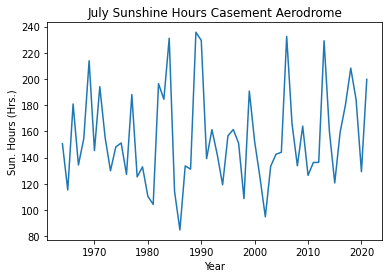

In [111]:
plt.plot(CA_sun.index, CA_sun[7])
plt.title("July Sunshine Hours Casement Aerodrome")
plt.xlabel("Year")
plt.ylabel("Sun. Hours (Hrs.)")

In [112]:
# TIME SERIES ANALYSIS

X_test = CA_sun.index.values[38:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in CA_sun.columns:
    # manual splitting
    y_train = CA_sun[col][:38]
    y_test = CA_sun[col][38:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (1, 1, 5))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arima_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  12.77 [50.80611229 59.38431655 51.32137923 57.40281685]
February  RMSE:  21.865 [68.41506857 64.51290221 68.05258825 68.77836281]
March  RMSE:  32.414 [ 76.24655571  94.52747646  92.30309401 105.28937035]
April  RMSE:  41.625 [130.14163182 133.2717076  140.67545619 142.34627978]
May  RMSE:  37.505 [187.6720834  174.88883655 158.61226075 198.77667336]
June  RMSE:  34.577 [170.65424091 152.57329033 164.35247484 159.67613921]
July  RMSE:  41.03 [197.45759382 122.54941175 142.07300817 168.51656709]
August  RMSE:  25.807 [152.77734364 158.39622543 152.88028272 154.18940765]
September  RMSE:  12.986 [112.52128146 123.48608203 134.17910588 118.23967541]
October  RMSE:  16.05 [104.36843028 101.76559719  95.15309293 101.87578584]
November  RMSE:  16.977 [64.49865007 55.65910267 60.13397746 62.69671045]
December  RMSE:  12.925 [48.09418488 57.26783547 55.40512333 66.23603415]


## Dataset 2 - Historic data from Malin Head

### Malin Head - EDA

In [12]:
df_2 = pd.read_csv("../Datasets/damo/mly1575.csv",
                   skiprows=19,
                   parse_dates= {"date" : ["year","month"]},
                   keep_date_col=True
                  )

In [114]:
df_2.head()

date  year month  meant  maxtp  mintp  mnmax  mnmin   rain  gmin  \
0 1955-05-01  1955     5    9.5   20.2    1.4   12.3    6.6   70.1  -0.6   
1 1955-06-01  1955     6   12.4   18.8    6.6   14.7   10.0   83.2  -0.3   
2 1955-07-01  1955     7   14.8   21.3    8.8   17.5   12.1   22.1   4.5   
3 1955-08-01  1955     8   15.8   27.1    9.5   18.7   12.9   27.3   5.6   
4 1955-09-01  1955     9   13.9   23.4    7.7   16.5   11.2  114.2   4.4   

   wdsp maxgt    sun  
0  14.6    48  250.1  
1  12.9    58  124.0  
2   6.2    33  213.3  
3   8.1    47  140.9  
4  16.0    50  121.9

In [115]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    800 non-null    datetime64[ns]
 1   year    800 non-null    object        
 2   month   800 non-null    object        
 3   meant   800 non-null    float64       
 4   maxtp   800 non-null    float64       
 5   mintp   800 non-null    float64       
 6   mnmax   800 non-null    float64       
 7   mnmin   800 non-null    float64       
 8   rain    800 non-null    float64       
 9   gmin    800 non-null    float64       
 10  wdsp    800 non-null    object        
 11  maxgt   800 non-null    object        
 12  sun     800 non-null    object        
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 81.4+ KB


In [13]:
df_2.year = pd.to_numeric(df_2.year)
df_2.month = pd.to_numeric(df_2.month)
df_2.sun = pd.to_numeric(df_2.sun, errors='coerce')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    800 non-null    datetime64[ns]
 1   year    800 non-null    int64         
 2   month   800 non-null    int64         
 3   meant   800 non-null    float64       
 4   maxtp   800 non-null    float64       
 5   mintp   800 non-null    float64       
 6   mnmax   800 non-null    float64       
 7   mnmin   800 non-null    float64       
 8   rain    800 non-null    float64       
 9   gmin    800 non-null    float64       
 10  wdsp    800 non-null    object        
 11  maxgt   800 non-null    object        
 12  sun     668 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 81.4+ KB


In [85]:
df_2.month.value_counts()

5     67
6     67
7     67
8     67
9     67
10    67
11    67
12    67
1     66
2     66
3     66
4     66
Name: month, dtype: int64

As with the Casement Aerodrome data we can see that we are missing some observations. In this case the first four months of 1955. Since we are more interested in the later years instead o imputing values here we ill simply drop the rows containing the other observations or 1955.

In [14]:
df_2 = df_2.iloc[8:]
df_2.reset_index(drop=True, inplace=True)
df_2.head()

date  year  month  meant  maxtp  mintp  mnmax  mnmin  rain  gmin  \
0 1956-01-01  1956      1    5.3   10.8   -3.1    7.5    3.1  99.1  -2.3   
1 1956-02-01  1956      2    4.0   10.1   -3.4    6.4    1.5  75.4  -4.4   
2 1956-03-01  1956      3    7.3   12.9    1.3    9.9    4.8  26.6  -1.6   
3 1956-04-01  1956      4    7.4   14.2    0.1   10.0    4.7  31.0  -2.2   
4 1956-05-01  1956      5   10.6   17.2    3.4   13.5    7.8  51.3   0.3   

   wdsp maxgt    sun  
0  15.7    70   31.1  
1  12.2    66   63.2  
2  16.0        119.7  
3  12.0    43  200.4  
4  15.0    55  181.6

In [87]:
df_2.month.value_counts()

1     66
2     66
3     66
4     66
5     66
6     66
7     66
8     66
9     66
10    66
11    66
12    66
Name: month, dtype: int64

Text(0.5, 0, '')

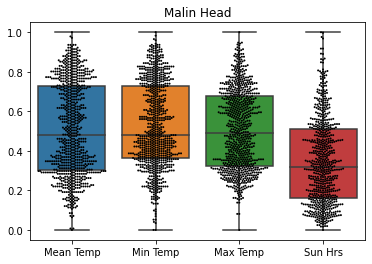

In [128]:
scaler = MinMaxScaler()
df_2_scaled = scaler.fit_transform(df_2[["meant", "mintp", "maxtp", "sun"]])
ax = sns.boxplot(data=df_2_scaled)
sns.swarmplot(data=df_2_scaled, color='k', size=2)

plt.title("Malin Head")
xticks = ["Mean Temp", "Min Temp", "Max Temp", "Sun Hrs"]
ax.set_xticklabels(xticks)
plt.xlabel("")

In [77]:
df_2[["meant", "maxtp", "mintp", "sun"]].describe().to_csv("MH_descriptive.csv")

### Malin Head Mean Temperature

In [120]:
MH_meant = df_2.pivot(index="year", columns="month", values="meant")
MH_meant.head()

month   1    2    3    4     5     6     7     8     9     10   11   12
year                                                                   
1956   5.3  4.0  7.3  7.4  10.6  11.3  13.7  12.7  13.2  10.6  8.3  7.0
1957   6.1  5.5  9.1  8.4  10.2  13.4  13.6  13.8  12.0  10.9  8.0  6.5
1958   5.1  5.5  4.4  7.7   8.9  12.1  13.9  14.5  14.1  11.1  8.7  6.1
1959   4.1  6.7  7.4  8.3  11.0  13.5  14.7  15.2  14.3  12.6  7.7  6.6
1960   5.7  4.7  7.0  8.6  11.8  13.9  14.1  13.7  12.5  10.6  7.6  5.1

In [121]:
# TIME SERIES ANALYSIS

X_test = MH_meant.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_meant.columns:
    # manual splitting
    y_train = MH_meant[col][:44]
    y_test = MH_meant[col][44:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  0.938 [5.71421708 6.2687092  5.46240394 5.85885717]
February  RMSE:  2.919 [6.7299818  6.71051029 6.83330867 6.83741759]
March  RMSE:  1.877 [7.22704105 7.66855747 7.55286482 7.95353562]
April  RMSE:  1.403 [8.7382099  8.65330191 7.86491201 8.73784943]
May  RMSE:  0.899 [11.05383797 11.16443736 11.278032   10.26775515]
June  RMSE:  1.381 [11.94841565 11.93813328 12.50640273 11.84861741]
July  RMSE:  1.062 [13.44083067 14.14871375 15.18333342 15.1151043 ]
August  RMSE:  0.842 [12.95645291 15.11045433 14.94303958 15.70136038]
September  RMSE:  0.773 [13.89219401 13.63972224 13.42288456 13.18319215]
October  RMSE:  0.784 [10.97709195 11.08679838 10.47506753 10.2117889 ]
November  RMSE:  2.593 [ 9.34081005  8.49751061 10.46823412  9.19866356]
December  RMSE:  0.957 [6.57479824 6.57740411 6.94723616 6.81011693]


### Malin Head - Minimum Temperature

In [122]:
MH_mintp = df_2.pivot(index="year", columns="month", values="mintp")
MH_mintp.head()

month   1    2    3    4    5    6    7    8    9    10   11   12
year                                                             
1956  -3.1 -3.4  1.3  0.1  3.4  3.7  7.1  5.8  7.8  4.2  1.1 -0.2
1957  -0.3 -0.3  3.0  2.8  4.7  6.1  8.1  6.7  6.6  5.3  2.2 -1.8
1958  -3.2 -2.6 -2.6  1.6  1.6  6.8  7.5  8.8  8.4  5.1  2.1 -0.6
1959  -2.1 -2.0  0.9  0.9  1.5  6.1  8.3  9.9  7.5  3.7  1.2  2.0
1960  -2.8 -2.9  1.2  2.4  2.4  7.6  8.3  6.6  5.0  3.9  0.9 -0.6

Text(0, 0.5, 'Mean Temp. ($^{\\circ}C$)')

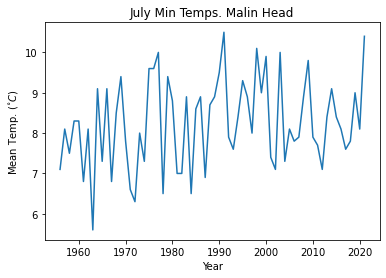

In [123]:
plt.plot(MH_mintp.index, MH_mintp[7])
plt.title("July Min Temps. Malin Head")
plt.xlabel("Year")
plt.ylabel(r"Mean Temp. ($^{\circ}C$)")

In [124]:
# TIME SERIES ANALYSIS

X_test = MH_mintp.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_mintp.columns:
    # manual splitting
    y_train = MH_mintp[col][:44]
    y_test = MH_mintp[col][44:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  2.732 [-4.41398548 -2.10611298 -2.75383282 -0.7383115 ]
February  RMSE:  1.957 [-1.33492791  1.87578167  0.06371225  1.02719228]
March  RMSE:  1.942 [-1.3828128   0.84459579  0.24789158  0.8940314 ]
April  RMSE:  1.559 [1.43225897 1.25259644 1.52043531 0.57026535]
May  RMSE:  1.757 [4.86914832 0.92482349 2.06719114 2.59996959]
June  RMSE:  2.474 [6.1865346  1.4418335  6.75340747 2.87277361]
July  RMSE:  1.442 [9.80304543 9.19199625 8.99945824 7.55159079]
August  RMSE:  1.153 [7.48954138 8.31236242 8.90627182 9.10716832]
September  RMSE:  2.362 [4.46878282 6.23685284 5.61059774 5.65168477]
October  RMSE:  2.061 [3.27589772 2.91487479 2.1784433  4.76347314]
November  RMSE:  2.423 [1.3838609  2.22298139 0.76314459 3.05623388]
December  RMSE:  1.692 [ 0.01425788 -2.33125847  0.6125948  -0.71927377]


### Malin Head - Maximum Temperature

In [125]:
MH_maxtp = df_2.pivot(index="year", columns="month", values="maxtp")
MH_maxtp.head()

month    1     2     3     4     5     6     7     8     9     10    11    12
year                                                                         
1956   10.8  10.1  12.9  14.2  17.2  18.4  19.8  19.6  19.3  17.0  13.2  12.6
1957   13.7  11.8  15.4  14.3  16.7  25.8  18.8  19.9  17.9  16.1  13.1  12.1
1958   13.4  11.1  13.3  16.6  18.3  17.9  20.7  21.6  21.7  17.1  14.3  11.1
1959   10.4  13.0  13.9  16.1  18.4  23.8  23.9  23.4  24.4  21.1  14.0  11.7
1960   12.3  12.2  13.3  14.9  19.2  21.6  19.7  21.7  18.8  16.2  13.6  10.6

In [126]:
# TIME SERIES ANALYSIS

X_test = MH_maxtp.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_maxtp.columns:
    # manual splitting
    y_train = MH_maxtp[col][:44]
    y_test = MH_maxtp[col][44:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.33 [10.88242374 11.97929648 13.13003488 11.64324873]
February  RMSE:  1.423 [11.84007774 10.5857512  11.36503969 10.85917201]
March  RMSE:  2.456 [12.74135585 13.70729194 14.39430929 12.74308464]
April  RMSE:  2.969 [17.89643691 15.58384544 17.484175   14.9859246 ]
May  RMSE:  3.139 [18.46237215 15.88260628 21.31356283 16.73307123]
June  RMSE:  1.922 [20.14793879 19.96014974 19.9016584  21.73697394]
July  RMSE:  2.499 [23.6840975  23.02899266 23.05843023 24.08324984]
August  RMSE:  2.617 [19.12187153 22.63970975 23.3681752  25.9625158 ]
September  RMSE:  1.719 [20.03747766 20.57785004 20.17709107 20.62998972]
October  RMSE:  2.204 [16.97053524 19.58492177 19.58405362 17.60434914]
November  RMSE:  1.368 [12.11075548 14.1404433  13.50625551 15.14240998]
December  RMSE:  1.235 [12.61256205 13.36374719 12.70805546 13.08491542]


### Malin Head - Sunshine Hours

In [127]:
MH_sun = df_2.pivot(index="year", columns="month", values="sun")
MH_sun.head()

month    1      2      3      4      5      6      7      8      9     10  \
year                                                                        
1956   31.1   63.2  119.7  200.4  181.6  198.8  151.3  185.9  101.8  85.1   
1957   58.5   99.9   66.1  194.0  215.5  286.7  120.5  120.5  105.1  50.3   
1958   42.6   49.7   97.6  135.3  226.4  142.6  185.0  135.4  106.1  79.2   
1959   81.3   71.4  127.9  159.6  264.5  207.0  104.1  132.1  153.8  98.1   
1960   42.3  109.5   84.1  169.1  216.2  223.3  153.2  191.5  149.6  54.8   

month    11    12  
year               
1956   41.0  23.5  
1957   52.4  30.3  
1958   54.0  37.7  
1959   72.5  29.0  
1960   59.5  52.9

In [129]:
MH_sun.tail()

month  1   2   3   4   5   6   7   8   9   10  11  12
year                                                 
2017  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2018  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2019  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2020  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2021  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

In [130]:
MH_sun.isna().sum()

month
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    11
dtype: int64

We can see here that the last 11 years are missing. We will try imputing values using interpolation. If this does not work, however, we will most likely have to drop those rows or attempt to find a replacement dataset.

In [131]:
np.array(MH_sun[7])

array([151.3, 120.5, 185. , 104.1, 153.2, 103.9, 136.1, 185.6,  94.3,
       133.1, 142.5, 115.1, 203.7, 132.6,  88.4, 157.8, 165.5, 123.7,
       160.3, 157.2, 103.9, 154.2, 105.2,  63.7, 117.7,  98. , 185.2,
       153.7, 131.8, 112.6,  94. ,  85.5, 135. , 163.8, 191.7, 156.6,
       119.6, 117.1, 130.7, 146.1, 134.5, 157.7,  84.2, 177.1, 180.1,
       137.6, 155.2, 122.4, 155.6, 100.9, 169.5, 211.6, 136.7, 194.5,
       117.8,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan])

In [132]:
pd.Series(MH_sun[7]).interpolate()

year
1956    151.3
1957    120.5
1958    185.0
1959    104.1
1960    153.2
        ...  
2017    117.8
2018    117.8
2019    117.8
2020    117.8
2021    117.8
Name: 7, Length: 66, dtype: float64

Unfortunately interpolation will not work here as the missing values are all located at the end of the dataframe. Let's have a look at the data for July to see what shape it is. Yang(2020) lists the common methods for imputation and their associated error for a small dataset, around half the size of the one we have here, so we will use that along with the data shape to inform our final decision.

Text(0, 0.5, 'Sun. Hours (Hrs.)')

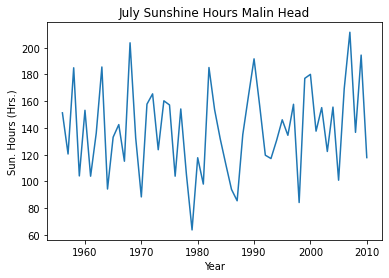

In [133]:
plt.plot(MH_sun.index, MH_sun[7])
plt.title("July Sunshine Hours Malin Head")
plt.xlabel("Year")
plt.ylabel("Sun. Hours (Hrs.)")

In [134]:
MH_sun[7].describe()

count     55.000000
mean     138.461818
std       33.474935
min       63.700000
25%      116.100000
50%      136.100000
75%      157.750000
max      211.600000
Name: 7, dtype: float64

In [135]:
MH_sun[7].median()

136.1

Text(0.5, 0, '')

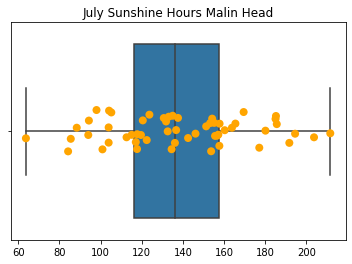

In [138]:
# MH_sun[7].plot.box()
sns.boxplot(MH_sun[7])
sns.stripplot(MH_sun[7], color='orange', size=8)
plt.title("July Sunshine Hours Malin Head")
plt.xlabel("")

It appears that imputation may not be the best way forward for this dataset. The plot shows some variation in the yearly values and a look at the descriptive statistics shows us that the std. dev. is $\approx$ half the minimum value while the maximum values is $\approx$ 4 times the minimum. In this case deletion may be the best approach but we will try both for the sake o completeness.

In [139]:
# imputation of the mean
MH_sun_mean = MH_sun[7].fillna(value=MH_sun[7].mean())

In [140]:
# deletion of missing values
MH_sun_del = MH_sun[7].dropna()

Now we can test each one in our regression to observe the differences in output.

In [141]:
# TIME SERIES ANALYSIS

X_test = MH_sun.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

y_train = MH_sun_mean[:44]
y_test = MH_sun_mean[44:]
 
# fitting the model
ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
ARIMAmodel = ARIMAmodel.fit()

# testing the model
y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
y_pred_df.index = X_test
y_pred_out = y_pred_df["Predictions"] 
    
# making our forecast
y_fore = ARIMAmodel.get_forecast(len(X_fore))
y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
print("July", 
      " RMSE: ", 
      np.round(arma_rmse, 3), 
      np.array(y_fore_df["Predictions"]))

July  RMSE:  27.746 [131.76941278 123.56196342 157.08438827 119.43339136]


In [142]:
len(MH_sun_del)

55

In [143]:
# TIME SERIES ANALYSIS

X_test = MH_sun_del.index.values[37:]
X_fore = np.array([2022, 2023, 2024, 2025])

y_train = MH_sun_del[:37]
y_test = MH_sun_del[37:]
 
# fitting the model
ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
ARIMAmodel = ARIMAmodel.fit()

# testing the model
y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
y_pred_df.index = X_test
y_pred_out = y_pred_df["Predictions"] 
    
# making our forecast
y_fore = ARIMAmodel.get_forecast(len(X_fore))
y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
print("July", 
      " RMSE: ", 
      np.round(arma_rmse, 3), 
      np.array(y_fore_df["Predictions"]))

July  RMSE:  429.098 [ 82.60012862  45.60021225   8.60033955 -28.39955737]


By inspection we can see that the deletions have had a drastic effect on the results. The RMSE has gone from $\sim$27 to $\sim$429 (the former can possibly be improved by tweaking the hyper parameters of the model). The predicted values have also seen a drastic change with one even being negative. Clearly this has not worked as it is impossible to have a negative number of hours of sunshine. As such we will proceed with the analysis using mean value imputation.

In [144]:
MH_sun.fillna(value=MH_sun.mean(), inplace=True)
MH_sun.tail()

month     1          2          3           4           5           6   \
year                                                                     
2017   39.76  65.101818  97.298182  153.661818  199.629091  175.265455   
2018   39.76  65.101818  97.298182  153.661818  199.629091  175.265455   
2019   39.76  65.101818  97.298182  153.661818  199.629091  175.265455   
2020   39.76  65.101818  97.298182  153.661818  199.629091  175.265455   
2021   39.76  65.101818  97.298182  153.661818  199.629091  175.265455   

month          7           8           9     10         11         12  
year                                                                   
2017   138.461818  140.796364  111.050909  77.9  45.592727  32.194545  
2018   138.461818  140.796364  111.050909  77.9  45.592727  32.194545  
2019   138.461818  140.796364  111.050909  77.9  45.592727  32.194545  
2020   138.461818  140.796364  111.050909  77.9  45.592727  32.194545  
2021   138.461818  140.796364  111.050909  77.9  45.592727  32.194545

In [145]:
# TIME SERIES ANALYSIS

X_test = MH_sun.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_sun.columns:
    # manual splitting
    y_train = MH_sun[col][:44]
    y_test = MH_sun[col][44:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  17.275 [30.31774168 31.28018014 33.11780037 25.09572201]
February  RMSE:  34.098 [31.81325597 36.51663016 27.19494175 47.57788063]
March  RMSE:  44.965 [ 60.14999355 115.16964264  27.22306792 116.84595046]
April  RMSE:  39.709 [123.50367477 142.9210493  139.78876215 133.66083965]
May  RMSE:  48.32 [143.70720511 179.03163614 210.54629332 181.8533991 ]
June  RMSE:  40.662 [128.47189615 189.12840367 157.25312411 151.78879228]
July  RMSE:  27.746 [131.76941278 123.56196342 157.08438827 119.43339136]
August  RMSE:  27.943 [144.27013973 173.79388508 158.06073538 185.37437414]
September  RMSE:  55.064 [135.75160489 124.92471878 146.31799142 131.46295678]
October  RMSE:  10.964 [89.24219505 82.08407489 54.31697426 86.2556599 ]
November  RMSE:  13.049 [51.94533018 37.25019075 51.56981831 40.73157839]
December  RMSE:  9.865 [39.14803312 36.04881814 35.97345361 45.34564151]


## Dataset 3 - Historic data from Valentia

### Valentia - EDA

In [35]:
df_3 = pd.read_csv("../Datasets/damo/mly2275.csv",
                   skiprows=19,
                   parse_dates= {"date" : ["year","month"]},
                   keep_date_col=True
                  )
df_3.head()

date  year month  meant  maxtp  mintp  mnmax  mnmin   rain  gmin  \
0 1939-10-01  1939    10   10.0   16.8    0.0   13.2    6.7  105.5  -4.4   
1 1939-11-01  1939    11   10.3   14.0    4.0   12.4    8.1  251.9   0.5   
2 1939-12-01  1939    12    6.0   13.6   -3.3    8.7    3.3  116.9  -7.8   
3 1940-01-01  1940     1    5.8   12.3   -5.6    8.4    3.3  163.8  -8.4   
4 1940-02-01  1940     2    7.9   12.8   -3.9   10.1    5.7  179.6  -5.8   

   wdsp maxgt    sun  
0   9.9    55  140.0  
1  13.9    60   36.4  
2  10.6    59   65.8  
3  11.6    51   76.3  
4  13.0    55   67.2

In [90]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    987 non-null    datetime64[ns]
 1   year    987 non-null    object        
 2   month   987 non-null    object        
 3   meant   987 non-null    float64       
 4   maxtp   987 non-null    float64       
 5   mintp   987 non-null    float64       
 6   mnmax   987 non-null    float64       
 7   mnmin   987 non-null    float64       
 8   rain    987 non-null    float64       
 9   gmin    987 non-null    object        
 10  wdsp    987 non-null    object        
 11  maxgt   987 non-null    object        
 12  sun     987 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 100.4+ KB


In [36]:
df_3.year = pd.to_numeric(df_3.year)
df_3.month = pd.to_numeric(df_3.month)
df_3.sun = pd.to_numeric(df_3.sun, errors='coerce')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    987 non-null    datetime64[ns]
 1   year    987 non-null    int64         
 2   month   987 non-null    int64         
 3   meant   987 non-null    float64       
 4   maxtp   987 non-null    float64       
 5   mintp   987 non-null    float64       
 6   mnmax   987 non-null    float64       
 7   mnmin   987 non-null    float64       
 8   rain    987 non-null    float64       
 9   gmin    987 non-null    object        
 10  wdsp    987 non-null    object        
 11  maxgt   987 non-null    object        
 12  sun     885 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(3)
memory usage: 100.4+ KB


In [92]:
df_3.sun.isna().sum()

102

In [93]:
df_3.tail()

date  year  month  meant  maxtp  mintp  mnmax  mnmin   rain  gmin  \
982 2021-08-01  2021      8   15.7   23.0    9.1   18.4   13.0   89.1   5.7   
983 2021-09-01  2021      9   15.4   27.9    9.2   17.9   12.9  121.8   5.1   
984 2021-10-01  2021     10   12.4   17.5    5.1   14.8    9.9  264.9   0.9   
985 2021-11-01  2021     11    9.9   15.0   -0.9   12.1    7.7   93.3  -5.3   
986 2021-12-01  2021     12    9.1   14.2    2.1   11.4    6.8  187.9  -2.0   

     wdsp maxgt  sun  
982   7.1    36  NaN  
983   6.9    33  NaN  
984   9.2    50  NaN  
985   8.6    46  NaN  
986  11.0    70  NaN

In [94]:
df_3.month.value_counts()

10    83
11    83
12    83
1     82
2     82
3     82
4     82
5     82
6     82
7     82
8     82
9     82
Name: month, dtype: int64

In [37]:
df_3 = df_3.iloc[3:]
df_3.reset_index(drop=True, inplace=True)
df_3.head()

date  year  month  meant  maxtp  mintp  mnmax  mnmin   rain  gmin  \
0 1940-01-01  1940      1    5.8   12.3   -5.6    8.4    3.3  163.8  -8.4   
1 1940-02-01  1940      2    7.9   12.8   -3.9   10.1    5.7  179.6  -5.8   
2 1940-03-01  1940      3    8.5   13.6   -1.2   11.0    6.0   84.8  -3.9   
3 1940-04-01  1940      4    9.7   17.8   -1.7   12.2    7.1   80.3  -4.4   
4 1940-05-01  1940      5   12.2   19.5    3.7   15.5    8.9   42.4   0.1   

   wdsp maxgt    sun  
0  11.6    51   76.3  
1  13.0    55   67.2  
2  12.0    52  119.0  
3  10.4    46  127.1  
4   9.0    35  235.6

Text(0.5, 0, '')

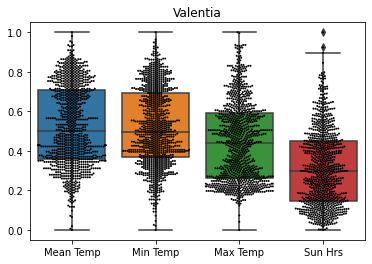

In [127]:
scaler = MinMaxScaler()
df_3_scaled = scaler.fit_transform(df_3[["meant", "mintp", "maxtp", "sun"]])
ax = sns.boxplot(data=df_3_scaled)
sns.swarmplot(data=df_3_scaled, color='k', size=2)

plt.title("Valentia")
xticks = ["Mean Temp", "Min Temp", "Max Temp", "Sun Hrs"]
ax.set_xticklabels(xticks)
plt.xlabel("")

In [78]:
df_3[["meant", "maxtp", "mintp", "sun"]].describe().to_csv("VA_descriptive.csv")

### Valentia - Mean Temperature

In [153]:
VA_meant = df_3.pivot(index="year", columns="month", values="meant")
VA_meant.head()

month   1    2    3     4     5     6     7     8     9     10   11   12
year                                                                    
1940   5.8  7.9  8.5   9.7  12.2  15.3  13.7  15.4  13.5  10.8  9.0  7.6
1941   4.9  5.9  7.1   7.9   9.9  13.9  14.5  14.5  14.9  12.4  8.3  9.1
1942   6.9  5.6  8.8  10.3  11.6  13.5  14.5  15.6  13.2  10.3  6.1  9.4
1943   8.1  8.6  8.7  10.4  11.2  13.5  15.4  14.6  13.0  11.3  9.0  7.0
1944   9.1  6.3  7.9  10.3  11.2  13.6  15.6  15.8  12.9  10.6  8.9  7.7

In [154]:
# TIME SERIES ANALYSIS

X_test = VA_meant.index.values[55:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_meant.columns:
    # manual splitting
    y_train = VA_meant[col][:55]
    y_test = VA_meant[col][55:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.033 [7.70280795 8.22092096 7.02355658 7.34307678]
February  RMSE:  1.602 [5.97438151 8.40661278 8.54498975 9.33232736]
March  RMSE:  4.535 [ 8.21571608  9.03379013  9.74245884 10.06057151]
April  RMSE:  1.465 [8.79959906 8.3917865  8.96827354 8.48340483]
May  RMSE:  0.89 [11.22782553 11.78221351 11.29387686 11.33787216]
June  RMSE:  0.92 [13.91088705 13.17841595 13.02788905 13.90320194]
July  RMSE:  0.915 [15.05697641 14.98358572 15.89870797 15.09709627]
August  RMSE:  0.989 [14.68823666 15.25918336 16.10400833 14.49413293]
September  RMSE:  1.379 [13.85653162 12.55924209 13.15970538 13.87621036]
October  RMSE:  2.505 [11.06033688 11.7793374   9.60101338  9.94445081]
November  RMSE:  0.983 [ 8.99192206  9.49187035 10.29582776  9.24321338]
December  RMSE:  1.942 [8.60576271 8.43055891 8.36425765 7.90033738]


### Valentia - Minimum Temperature

In [155]:
VA_mintp = df_3.pivot(index="year", columns="month", values="mintp")
VA_mintp.head()

month   1    2    3    4    5    6     7    8    9    10   11   12
year                                                              
1940  -5.6 -3.9 -1.2 -1.7  3.7  7.3   6.6  7.7  3.7  2.3 -0.9 -2.9
1941  -1.7 -2.1 -1.7 -0.1  1.1  6.7   7.9  8.4  6.3  0.0 -0.3  3.0
1942  -0.7 -5.4 -2.2  2.5  1.2  4.6   8.3  7.2  1.7  0.6 -2.3  1.7
1943   0.8  4.1 -1.2  3.9  3.6  7.8   8.4  7.2  3.0  3.3  1.2 -1.6
1944   3.7 -2.6 -2.2  0.6  1.4  8.0  10.3  8.4  3.6  4.0  2.5 -0.7

In [156]:
# TIME SERIES ANALYSIS

X_test = VA_mintp.index.values[55:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_mintp.columns:
    # manual splitting
    y_train = VA_mintp[col][:55]
    y_test = VA_mintp[col][55:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  2.695 [ 0.80194535 -0.22954661  1.79500171 -2.53773355]
February  RMSE:  1.725 [-1.26053302 -2.81986853 -0.96467521 -0.29332733]
March  RMSE:  2.162 [-1.93183861 -0.35676376  0.14380974 -1.82871037]
April  RMSE:  2.744 [2.44511479 2.44745106 3.63579786 3.66955601]
May  RMSE:  1.89 [4.36294668 3.98553117 2.61976658 4.8269013 ]
June  RMSE:  1.291 [5.89531136 5.63453946 5.89606079 6.46548913]
July  RMSE:  1.384 [9.3253057  7.71210612 7.9803235  8.4473584 ]
August  RMSE:  2.227 [6.33577944 7.4988042  6.15659078 6.37552917]
September  RMSE:  1.965 [4.91627599 4.21498277 3.81133164 4.73504734]
October  RMSE:  2.661 [2.29584168 1.28398927 3.44666726 1.92502581]
November  RMSE:  1.96 [ 1.20883644 -0.02261023  3.41723235  1.63541905]
December  RMSE:  3.936 [0.42142984 0.04687232 1.96693133 0.981153  ]


### Valentia - Maximum Temperature

In [157]:
VA_maxtp = df_3.pivot(index="year", columns="month", values="maxtp")
VA_maxtp.head()

month    1     2     3     4     5     6     7     8     9     10    11    12
year                                                                         
1940   12.3  12.8  13.6  17.8  19.5  25.6  22.7  24.1  21.1  15.9  14.6  13.1
1941   11.2  12.3  12.7  15.2  18.9  22.8  19.5  22.2  23.7  19.6  13.3  12.9
1942   12.6  10.7  16.2  18.9  17.6  27.2  21.3  23.8  18.6  15.8  13.4  12.9
1943   12.2  12.5  14.3  17.8  20.5  24.0  25.7  23.4  19.0  15.2  13.8  11.9
1944   12.8  12.4  18.6  16.9  26.1  23.4  23.3  24.5  19.5  15.7  13.9  12.4

In [158]:
# TIME SERIES ANALYSIS

X_test = VA_maxtp.index.values[55:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in MH_maxtp.columns:
    # manual splitting
    y_train = VA_maxtp[col][:55]
    y_test = VA_maxtp[col][55:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  0.701 [12.4755626  12.63695116 13.09002047 13.14616618]
February  RMSE:  1.498 [12.00955612 11.87080565 14.38530425 11.93428206]
March  RMSE:  2.696 [14.44458347 13.83946015 14.68249    14.25182151]
April  RMSE:  3.047 [13.82603791 19.13328583 18.55326259 16.44140851]
May  RMSE:  3.727 [21.2423824  24.97432605 23.305002   21.02360326]
June  RMSE:  3.474 [24.34250186 23.04530473 19.37331571 22.92359217]
July  RMSE:  4.272 [22.66378349 26.83536652 26.48142466 23.49080958]
August  RMSE:  2.968 [22.31046228 23.70303845 21.56083142 21.75307952]
September  RMSE:  2.631 [26.00182587 21.11866934 21.92022948 21.51139112]
October  RMSE:  2.005 [19.76280255 18.71372002 19.56247326 18.88239232]
November  RMSE:  1.342 [16.48078647 14.91492102 14.1229134  16.55615268]
December  RMSE:  0.897 [13.83211453 13.35281087 13.43326263 13.23611034]


### Valentia - Sunshine Hours

In [159]:
VA_sun = df_3.pivot(index="year", columns="month", values="sun")
VA_sun.head()

month    1     2      3      4      5      6      7      8      9      10  \
year                                                                        
1940   76.3  67.2  119.0  127.1  235.6  285.9  228.1  145.6  129.2   94.3   
1941   60.1  83.7  105.8  144.6  216.1  131.8  107.1  160.0  150.6  108.2   
1942   55.2  49.6  122.4  144.7  198.1  204.3  142.1  119.1  101.0  104.3   
1943   37.0  49.1  102.2  109.8  192.0  194.9  160.5  107.1  105.1   81.1   
1944   41.6  91.0  152.6  190.9  187.5  184.9  101.7  184.1  138.1   88.6   

month     11    12  
year                
1940    70.2  37.0  
1941    90.4  29.7  
1942   103.4  26.7  
1943    33.3  49.6  
1944    57.2  38.4

In [160]:
VA_sun[7].isna().sum()

9

In [161]:
np.array(VA_sun[7])

array([228.1, 107.1, 142.1, 160.5, 101.7, 141.1, 155.9,  87.7, 133.4,
       156.3, 179.1, 187.7, 142.6, 165.7, 104.6, 308.2, 138. , 110.1,
       118.6, 168.8, 147.2, 155.5, 127.4, 148. , 124.5, 174.6, 151. ,
        85.8, 204.9, 146.8, 104.3, 224.9, 132.1, 141.2, 107.4, 146.4,
       132.5, 140.9, 102.7,  80.9, 110.6, 126.1, 183.1, 170.4, 211. ,
        93. ,  63.3, 146.6,  95.5, 187.8, 194.3,  84.6, 129.5,  90.6,
       119.7, 105.3, 129.8, 157.9, 112.8, 158.2, 168.6, 176.8, 120.6,
        75.3, 178.5, 165.9, 180.6, 204.6, 107.2, 154.9,  84.6, 108.7,
         nan,   nan, 136.2,   nan,   nan,   nan,   nan,   nan,   nan,
         nan])

In [162]:
VA_sun.fillna(value=VA_sun.mean(), inplace=True)
VA_sun.tail()

month         1          2           3           4           5           6   \
year                                                                          
2017   47.656757  65.127027  101.848649  152.665753  187.249315  166.964384   
2018   47.656757  65.127027  101.848649  152.665753  187.249315  166.964384   
2019   47.656757  65.127027  101.848649  152.665753  187.249315  166.964384   
2020   47.656757  65.127027  101.848649  152.665753  187.249315  166.964384   
2021   47.656757  65.127027  101.848649  152.665753  187.249315  166.964384   

month          7           8           9          10         11         12  
year                                                                        
2017   141.765753  144.638356  112.093151  84.018919  54.672973  38.433784  
2018   141.765753  144.638356  112.093151  84.018919  54.672973  38.433784  
2019   141.765753  144.638356  112.093151  84.018919  54.672973  38.433784  
2020   141.765753  144.638356  112.093151  84.018919  54.672973  38.433784  
2021   141.765753  144.638356  112.093151  84.018919  54.672973  38.433784

Text(0, 0.5, 'Sun. Hours (Hrs.)')

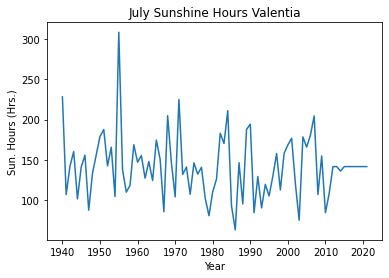

In [163]:
plt.plot(VA_sun.index, np.array(VA_sun[7]))
plt.title("July Sunshine Hours Valentia")
plt.xlabel("Year")
plt.ylabel("Sun. Hours (Hrs.)")

In [164]:
# TIME SERIES ANALYSIS

X_test = VA_sun.index.values[44:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in VA_sun.columns:
    # manual splitting
    y_train = VA_sun[col][:44]
    y_test = VA_sun[col][44:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  34.187 [31.99123969 34.5634279  39.83502976 27.27050281]
February  RMSE:  24.866 [60.01236238 45.38592591 42.87438075 68.75511668]
March  RMSE:  35.245 [108.76423698 121.48485974  93.00137706  68.44124636]
April  RMSE:  31.735 [133.88415612 167.47284205 116.4252766  160.73184638]
May  RMSE:  47.158 [174.62233448 187.95211379 169.50492679 162.04218951]
June  RMSE:  51.83 [194.33075372 154.85239758 168.18439235 139.18952641]
July  RMSE:  38.833 [169.65573691  88.95397277 114.7823094  151.34999206]
August  RMSE:  32.124 [190.03629477 188.22365544 150.27096537 122.04237605]
September  RMSE:  200.58 [74.85615024 81.83995047 61.00499544 45.07507822]
October  RMSE:  38.983 [51.4700929  63.00825855 92.94043826 73.00832145]
November  RMSE:  35.918 [39.81392199 42.14112274 30.52985326 36.92124646]
December  RMSE:  23.456 [33.37671793  7.18257188 26.20439643 37.66768614]


## Dataset 4 - Historic data from Belmullet

### Belmullet - EDA

In [46]:
df_4 = pd.read_csv("../Datasets/damo/mly2375.csv",
                   skiprows=19,
                   parse_dates= {"date" : ["year","month"]},
                   keep_date_col=True
                  )
df_4.head()

date  year month meant maxtp mintp mnmax mnmin   rain  gmin  wdsp  \
0 1956-09-01  1956     9                                 49.9         6.4   
1 1956-10-01  1956    10  10.3  17.1   1.2  13.3   7.4   98.8  -1.3  12.4   
2 1956-11-01  1956    11   8.5  14.0  -0.6  10.8   6.2   51.6  -2.6  13.3   
3 1956-12-01  1956    12   7.5  13.1   1.3   9.9   5.2  180.6  -0.6  16.6   
4 1957-01-01  1957     1   6.5  13.2  -1.7   9.1   3.9  148.5  -3.3  15.4   

  maxgt   sun  
0    62  47.8  
1    58  97.1  
2    72  45.4  
3    81  28.6  
4    94  56.3

In [98]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    779 non-null    datetime64[ns]
 1   year    779 non-null    object        
 2   month   779 non-null    object        
 3   meant   779 non-null    object        
 4   maxtp   779 non-null    object        
 5   mintp   779 non-null    object        
 6   mnmax   779 non-null    object        
 7   mnmin   779 non-null    object        
 8   rain    779 non-null    float64       
 9   gmin    779 non-null    object        
 10  wdsp    779 non-null    float64       
 11  maxgt   779 non-null    object        
 12  sun     779 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 79.2+ KB


In [47]:
df_4 = df_4.iloc[4:]
df_4.reset_index(drop=True, inplace=True)
df_4.head()

date  year month meant maxtp mintp mnmax mnmin   rain  gmin  wdsp  \
0 1957-01-01  1957     1   6.5  13.2  -1.7   9.1   3.9  148.5  -3.3  15.4   
1 1957-02-01  1957     2   5.9  11.5  -2.2   8.6   3.1  137.6  -3.9  13.1   
2 1957-03-01  1957     3   9.5  15.1   1.4  11.9   7.2   97.0  -0.8  12.3   
3 1957-04-01  1957     4   9.3  16.1   2.5  12.6   6.0   48.2  -0.2  10.7   
4 1957-05-01  1957     5  10.9  20.8   3.5  14.6   7.2   40.4   2.1  10.4   

  maxgt    sun  
0    94   56.3  
1    91  100.4  
2    47   87.0  
3    47  215.3  
4    45  228.4

In [100]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    775 non-null    datetime64[ns]
 1   year    775 non-null    object        
 2   month   775 non-null    object        
 3   meant   775 non-null    object        
 4   maxtp   775 non-null    object        
 5   mintp   775 non-null    object        
 6   mnmax   775 non-null    object        
 7   mnmin   775 non-null    object        
 8   rain    775 non-null    float64       
 9   gmin    775 non-null    object        
 10  wdsp    775 non-null    float64       
 11  maxgt   775 non-null    object        
 12  sun     775 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 78.8+ KB


In [48]:
df_4.year = pd.to_numeric(df_4.year)
df_4.month = pd.to_numeric(df_4.month)
df_4.meant = pd.to_numeric(df_4.meant)
df_4.mintp = pd.to_numeric(df_4.mintp)
df_4.maxtp = pd.to_numeric(df_4.maxtp)
df_4.sun = pd.to_numeric(df_4.sun, errors='coerce')
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    775 non-null    datetime64[ns]
 1   year    775 non-null    int64         
 2   month   775 non-null    int64         
 3   meant   775 non-null    float64       
 4   maxtp   775 non-null    float64       
 5   mintp   775 non-null    float64       
 6   mnmax   775 non-null    object        
 7   mnmin   775 non-null    object        
 8   rain    775 non-null    float64       
 9   gmin    775 non-null    object        
 10  wdsp    775 non-null    float64       
 11  maxgt   775 non-null    object        
 12  sun     692 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 78.8+ KB


In [102]:
df_4.tail()

date  year  month  meant  maxtp  mintp mnmax mnmin   rain  gmin  \
770 2021-08-01  2021      8   15.6   23.8    8.1  18.5  12.7  108.6   5.8   
771 2021-09-01  2021      9   14.7   21.5    8.1  17.1  12.2   99.4   4.6   
772 2021-10-01  2021     10   12.1   16.6    5.7  14.3   9.9  222.4   2.0   
773 2021-11-01  2021     11   10.0   14.4    3.9  11.9   8.1   96.6   1.7   
774 2021-12-01  2021     12    7.7   12.6    0.6   9.7   5.6  108.1  -2.8   

     wdsp maxgt  sun  
770   8.8    51  NaN  
771   9.7    47  NaN  
772  12.1    48  NaN  
773  12.6    50  NaN  
774  12.4    59  NaN

In [103]:
len(df_4)

775

775 rows means there are missing observations somewhere.

In [104]:
df_4.month.value_counts()

1     65
2     65
3     65
4     65
5     65
6     65
7     65
8     64
9     64
10    64
11    64
12    64
Name: month, dtype: int64

In [105]:
df_4.year.value_counts()

1957    12
1958    12
1991    12
1992    12
1993    12
        ..
1984    12
1985    12
1986    12
2021    12
2012     7
Name: year, Length: 65, dtype: int64

In [49]:
df_4.loc[df_4.year == 2012]

date  year  month  meant  maxtp  mintp mnmax mnmin   rain  gmin  \
660 2012-01-01  2012      1    7.9   11.7    1.4  10.1   5.7  123.6  -2.2   
661 2012-02-01  2012      2    8.4   12.1   -1.0  10.0   6.8   69.4  -4.2   
662 2012-03-01  2012      3    9.6   22.2    1.8  12.6   6.5   41.4  -2.2   
663 2012-04-01  2012      4    8.1   13.6    0.7  11.4   4.9   79.7  -2.6   
664 2012-05-01  2012      5   11.8   26.1    0.6  15.4   8.2   52.1  -2.2   
665 2012-06-01  2012      6   12.8   19.2    4.7  15.7   9.9  110.0   1.5   
666 2012-07-01  2012      7   13.7   19.2    7.6  16.5  11.0   95.2   4.8   

     wdsp maxgt    sun  
660  14.2    72   34.9  
661  12.8    49   38.2  
662  11.8    51  128.3  
663  10.6    49  204.7  
664  10.1    49  199.2  
665   9.7    44  149.0  
666   9.9    43  114.7

So we know the we're missing data from Aug. to Dec. 2012. We'll now add rows for those observations, initially fill them with NaN's and then impute values by polynomial interpolation.

Before we do that, though, we'll first impute the mean for each specific month into all the missing sun values. That way the interpolation will only impute the observations we are adding.

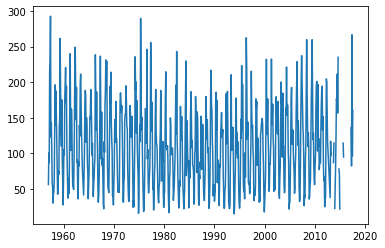

In [107]:
plt.plot(df_4.date, df_4.sun)

In [50]:
length = df_4.sun.isna().sum()

for i in range(length):
    # assigns mean value of sun at every month which is the same as the month being filled
    # i.e. jan. sun = mean val. of sun for all month == jan.
    df_4.sun.iloc[i-length] = df_4.sun[df_4.month==df_4.month.iloc[i-length]].mean()

df_4.tail()

date  year  month  meant  maxtp  mintp mnmax mnmin   rain  gmin  \
770 2021-08-01  2021      8   15.6   23.8    8.1  18.5  12.7  108.6   5.8   
771 2021-09-01  2021      9   14.7   21.5    8.1  17.1  12.2   99.4   4.6   
772 2021-10-01  2021     10   12.1   16.6    5.7  14.3   9.9  222.4   2.0   
773 2021-11-01  2021     11   10.0   14.4    3.9  11.9   8.1   96.6   1.7   
774 2021-12-01  2021     12    7.7   12.6    0.6   9.7   5.6  108.1  -2.8   

     wdsp maxgt         sun  
770   8.8    51  146.065889  
771   9.7    47  115.711450  
772  12.1    48   85.505263  
773  12.6    50   50.857143  
774  12.4    59   35.970175

In [51]:
aug = ["2012-08-01", 2012, 8, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

sept = ["2012-09-01", 2012, 9, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

octo = ["2012-10-1", 2012, 10, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

nov = ["2012-11-1", 2012, 11, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

dec = ["2012-12-1", 2012, 12, np.nan, np.nan, np.nan, 
       np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

In [52]:
# adding the new observations
new_df = pd.DataFrame([aug, sept, octo, nov, dec], columns=df_4.columns)
df_4 = pd.concat([df_4.iloc[:667], new_df, df_4.iloc[667:]], ignore_index = True)
df_4.date = pd.to_datetime(df_4.date)

In [53]:
df_4.loc[df_4.year == 2012]

date  year  month  meant  maxtp  mintp mnmax mnmin   rain  gmin  \
660 2012-01-01  2012      1    7.9   11.7    1.4  10.1   5.7  123.6  -2.2   
661 2012-02-01  2012      2    8.4   12.1   -1.0  10.0   6.8   69.4  -4.2   
662 2012-03-01  2012      3    9.6   22.2    1.8  12.6   6.5   41.4  -2.2   
663 2012-04-01  2012      4    8.1   13.6    0.7  11.4   4.9   79.7  -2.6   
664 2012-05-01  2012      5   11.8   26.1    0.6  15.4   8.2   52.1  -2.2   
665 2012-06-01  2012      6   12.8   19.2    4.7  15.7   9.9  110.0   1.5   
666 2012-07-01  2012      7   13.7   19.2    7.6  16.5  11.0   95.2   4.8   
667 2012-08-01  2012      8    NaN    NaN    NaN   NaN   NaN    NaN   NaN   
668 2012-09-01  2012      9    NaN    NaN    NaN   NaN   NaN    NaN   NaN   
669 2012-10-01  2012     10    NaN    NaN    NaN   NaN   NaN    NaN   NaN   
670 2012-11-01  2012     11    NaN    NaN    NaN   NaN   NaN    NaN   NaN   
671 2012-12-01  2012     12    NaN    NaN    NaN   NaN   NaN    NaN   NaN   

     wdsp maxgt    sun  
660  14.2    72   34.9  
661  12.8    49   38.2  
662  11.8    51  128.3  
663  10.6    49  204.7  
664  10.1    49  199.2  
665   9.7    44  149.0  
666   9.9    43  114.7  
667   NaN   NaN    NaN  
668   NaN   NaN    NaN  
669   NaN   NaN    NaN  
670   NaN   NaN    NaN  
671   NaN   NaN    NaN

In [54]:
# imputing values for meant, mintp, maxtp
df_4.meant.interpolate(method='polynomial', order=2, inplace=True)
df_4.meant.iloc[665:673]

665    12.800000
666    13.700000
667    13.759994
668    12.729196
669    10.607606
670     8.350992
671     6.915123
672     6.300000
Name: meant, dtype: float64

In [113]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    780 non-null    datetime64[ns]
 1   year    780 non-null    int64         
 2   month   780 non-null    int64         
 3   meant   780 non-null    float64       
 4   maxtp   775 non-null    float64       
 5   mintp   775 non-null    float64       
 6   mnmax   775 non-null    object        
 7   mnmin   775 non-null    object        
 8   rain    775 non-null    float64       
 9   gmin    775 non-null    object        
 10  wdsp    775 non-null    float64       
 11  maxgt   775 non-null    object        
 12  sun     767 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 79.3+ KB


In [55]:
df_4.mintp.interpolate(method='polynomial', order=2, inplace=True)
df_4.maxtp.interpolate(method='polynomial', order=2, inplace=True)

In [56]:
df_4.sun.interpolate(method='polynomial', order=2, inplace=True)

In [57]:
df_4.mintp.iloc[665:673]

665    4.700000
666    7.600000
667    8.897778
668    8.693638
669    6.987580
670    4.506504
671    1.977310
672   -0.600000
Name: mintp, dtype: float64

In [117]:
len(df_4)/12

65.0

Text(0.5, 0, '')

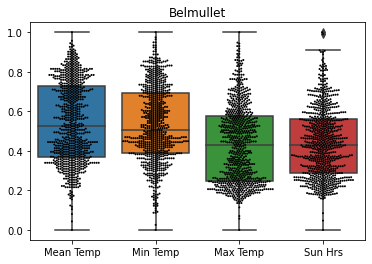

In [126]:
scaler = MinMaxScaler()
df_4_scaled = scaler.fit_transform(df_4[["meant", "mintp", "maxtp", "sun"]])
ax = sns.boxplot(data=df_4_scaled)
sns.swarmplot(data=df_4_scaled, color='k', size=2)

plt.title("Belmullet")
xticks = ["Mean Temp", "Min Temp", "Max Temp", "Sun Hrs"]
ax.set_xticklabels(xticks)
plt.xlabel("")

In [79]:
df_4[["meant", "maxtp", "mintp", "sun"]].describe().to_csv("BM_descriptive.csv")

### Belmullet - Mean Temperature

In [201]:
BM_meant = df_4.pivot(index="year", columns="month", values="meant")
BM_meant.head()

month   1    2    3    4     5     6     7     8     9     10   11   12
year                                                                   
1957   6.5  5.9  9.5  9.3  10.9  14.1  14.3  14.3  12.6  11.3  7.9  7.4
1958   5.8  6.4  5.4  8.5   9.4  13.0  14.3  14.7  14.4  11.2  9.2  6.0
1959   4.3  7.1  7.8  8.7  11.8  13.5  14.5  14.8  14.4  12.6  8.2  6.8
1960   5.6  5.0  7.6  9.1  11.8  13.6  14.2  13.9  13.1  10.1  8.1  5.8
1961   5.5  7.9  9.4  9.2  10.7  12.4  12.8  13.7  13.0  10.4  7.5  4.4

In [202]:
# TIME SERIES ANALYSIS

X_test = BM_meant.index.values[43:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in BM_meant.columns:
    # manual splitting
    y_train = BM_meant[col][:43]
    y_test = BM_meant[col][43:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.192 [7.56650529 7.16835107 5.79637771 6.41638624]
February  RMSE:  1.418 [7.80719838 5.80917606 6.8990558  7.21627664]
March  RMSE:  2.533 [7.99633785 8.37353285 8.88601424 8.64758498]
April  RMSE:  2.357 [ 9.87011415  9.45049272  9.13962641 10.19263469]
May  RMSE:  2.491 [11.64731884 11.93376635 13.12564211 12.52872887]
June  RMSE:  1.178 [12.68548841 13.68602544 13.901066   13.13450857]
July  RMSE:  1.609 [14.14004888 15.23520606 16.21035278 16.35451505]
August  RMSE:  1.078 [13.76420595 15.66912277 15.12432497 16.3746881 ]
September  RMSE:  1.295 [13.45722505 13.55687523 13.07702139 14.08461996]
October  RMSE:  0.922 [11.27596799 11.57410158 11.07169636 11.33192052]
November  RMSE:  1.189 [8.54009907 8.37167496 9.92629432 9.36478586]
December  RMSE:  1.163 [7.30616773 6.79005231 6.33570354 7.599013  ]


### Belmullet - Minimum Temperature

In [203]:
BM_mintp = df_4.pivot(index="year", columns="month", values="mintp")
BM_mintp.head()

month   1    2    3    4    5    6    7    8    9    10   11   12
year                                                             
1957  -1.7 -2.2  1.4  2.5  3.5  3.8  9.3  5.2  6.2  4.3 -0.2 -2.2
1958  -4.8 -1.7 -2.6 -0.4  2.5  6.7  6.2  8.0  4.8  2.7  0.1 -1.6
1959  -4.2 -3.3  1.0  1.9  1.7  5.8  8.5  8.2  7.2  5.1 -1.7 -2.1
1960  -3.8 -2.3 -0.9  1.6  2.6  6.6  7.9  5.2  8.7  2.3 -0.8 -0.9
1961  -1.1  1.2  3.2 -1.1  3.3  5.2  6.3  7.3  5.7  4.5  0.6 -5.1

In [204]:
# TIME SERIES ANALYSIS

X_test = BM_mintp.index.values[43:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in BM_mintp.columns:
    # manual splitting
    y_train = BM_mintp[col][:43]
    y_test = BM_mintp[col][43:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.92 [-0.03051485 -4.39348024 -2.785997   -3.57551772]
February  RMSE:  1.561 [-1.66773755 -1.93908496 -1.65926922  0.70843306]
March  RMSE:  3.271 [-1.06108124  0.39009557  0.99716478  0.72728715]
April  RMSE:  2.227 [1.64616773 0.48420048 2.12979957 3.26409386]
May  RMSE:  1.844 [3.14641808 3.5258885  2.09859031 2.75363536]
June  RMSE:  1.679 [5.79409876 6.73524777 6.33085955 6.5848854 ]
July  RMSE:  1.254 [10.864457    9.25656565  7.26609812  8.06725457]
August  RMSE:  1.399 [8.08066735 6.90155494 6.42304284 8.23305008]
September  RMSE:  1.778 [4.83343237 4.15334509 5.51834062 5.71261694]
October  RMSE:  2.236 [5.5084468  4.56181043 1.85805947 3.24080532]
November  RMSE:  8.657 [2.28628523 3.60318119 2.95069084 4.14593298]
December  RMSE:  2.44 [-1.07029465 -0.96188098  1.67071955 -0.78577405]


### Belmullet - Maximum Tepmerature

In [205]:
BM_maxtp = df_4.pivot(index="year", columns="month", values="maxtp")
BM_maxtp.head()

month    1     2     3     4     5     6     7     8     9     10    11    12
year                                                                         
1957   13.2  11.5  15.1  16.1  20.8  28.3  20.9  22.5  19.1  15.3  12.7  13.1
1958   12.8  12.3  12.6  17.9  20.2  18.8  21.7  18.8  21.1  16.8  13.8  11.7
1959   10.2  12.6  13.8  15.3  23.3  22.3  21.7  21.8  23.2  21.7  14.8  11.8
1960   12.6  12.0  14.6  17.1  19.0  23.3  17.9  19.7  18.3  17.2  14.7  11.2
1961   11.6  11.7  15.2  16.4  19.9  18.4  17.2  20.6  20.2  17.7  13.6  12.9

In [206]:
# TIME SERIES ANALYSIS

X_test = BM_maxtp.index.values[43:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in BM_maxtp.columns:
    # manual splitting
    y_train = BM_maxtp[col][:43]
    y_test = BM_maxtp[col][43:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  1.634 [11.97679322 12.528635   13.42796331 11.2968062 ]
February  RMSE:  1.682 [11.7481819  11.36598507 12.39110414 12.61669166]
March  RMSE:  4.042 [12.70637734 12.51656123 12.00331468 12.85060161]
April  RMSE:  3.065 [14.86744027 16.78434738 18.91421722 14.78529115]
May  RMSE:  3.319 [23.22271421 22.47485651 21.2020498  19.7718254 ]
June  RMSE:  2.587 [19.82625855 21.36461555 20.46214902 24.01019835]
July  RMSE:  3.448 [24.27860213 26.48490561 23.71773118 22.24251424]
August  RMSE:  2.687 [18.25741    19.3671287  22.5506566  20.69296224]
September  RMSE:  3.1 [21.33651488 20.36661002 18.40074266 21.52845088]
October  RMSE:  6.171 [20.81179329 21.13675476 18.48561633 19.7027277 ]
November  RMSE:  1.33 [14.25032784 14.68549555 13.28455374 14.73230001]
December  RMSE:  1.85 [12.02411554 13.92102905 13.68153182 13.82875355]


### Belmullet - Sunshine Hours

In [207]:
BM_sun = df_4.pivot(index="year", columns="month", values="sun")
BM_sun.head()

month    1      2      3      4      5      6      7      8      9     10  \
year                                                                        
1957   56.3  100.4   87.0  215.3  228.4  292.7  123.0  143.0  107.4  58.5   
1958   43.7   45.7   64.5  135.2  196.3  139.9  187.9  152.4  117.8  80.5   
1959   75.2   70.7  138.1  148.7  261.7  198.1  129.8  110.0  175.4  93.1   
1960   61.5  105.6   98.1  175.0  198.4  220.6  171.3  194.2  110.1  82.0   
1961   64.9   43.6   81.1  160.2  240.1  145.4  104.4  162.4  138.5  86.1   

month    11    12  
year               
1957   52.7  30.2  
1958   42.6  44.9  
1959   65.2  27.5  
1960   48.7  37.1  
1961   53.6  60.1

In [208]:
# TIME SERIES ANALYSIS

X_test = BM_sun.index.values[43:]
X_fore = np.array([2022, 2023, 2024, 2025])

for col in BM_sun.columns:
    # manual splitting
    y_train = BM_sun[col][:43]
    y_test = BM_sun[col][43:]
 
    # fitting the model
    ARIMAmodel = ARIMA(y_train, order = (9, 2, 7))
    ARIMAmodel = ARIMAmodel.fit()

    # testing the model
    y_pred = ARIMAmodel.get_forecast(len(X_test))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], 
                                                  end=y_pred_df.index[-1])
    
    y_pred_df.index = X_test
    y_pred_out = y_pred_df["Predictions"] 
    
    # making our forecast
    y_fore = ARIMAmodel.get_forecast(len(X_fore))
    y_fore_df = y_fore.conf_int(alpha = 0.05) 
    
    y_fore_df["Predictions"] = ARIMAmodel.predict(start=y_fore_df.index[0], 
                                                  end=y_fore_df.index[-1])

    arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
    
    print(month[col-1], 
          " RMSE: ", 
          np.round(arma_rmse, 3), 
          np.array(y_fore_df["Predictions"]))

January  RMSE:  27.471 [25.93158    45.43898095 20.87738362 33.57216886]
February  RMSE:  35.903 [55.49036444 65.9675809  48.29509053 44.06964513]
March  RMSE:  49.848 [67.84651976 79.82776694 70.04475514 62.91383008]
April  RMSE:  47.023 [133.27707465 108.1087657  126.25335591 148.68361253]
May  RMSE:  52.629 [149.25048913 207.11139949 152.36334669 154.37963572]
June  RMSE:  56.52 [141.7239622  138.57052953 135.01888422 113.32471047]
July  RMSE:  33.635 [117.12161515 104.75036834 144.84706524 112.87179369]
August  RMSE:  50.682 [104.3505989  137.70417884 113.92186616 129.96526071]
September  RMSE:  26.291 [148.49846763 127.77050591 135.40938796 115.41596846]
October  RMSE:  33.72 [67.18958857 67.55757505 70.82601129 69.00574859]
November  RMSE:  28.408 [28.06588876 42.07984696 27.5848649  32.51041995]
December  RMSE:  27.647 [30.63582103 34.01930507 43.06865652 57.07013597]


## Setting up the GRNN

`X` here will be the input matrix for equations $\ref{eq:AP}$, $\ref{eq:omega}$, $\ref{eq:delta}$, $\ref{eq:harg}$ & $\ref{eq:thorn}$ while `y` will be the vectors of $ET_0$ values calculated by each of the equations $\ref{eq:harg}$ & $\ref{eq:thorn}$.

The inputs for the equations are 
* the `a` and `b` coefficients which have been set by results in prior work (ishola, et.al., 2018)
* the latitude of Ireland ($\phi$)
* the day number (i)
* the average sunshine per day ($s_i$)
* the minimum and maximum daily temperatures fr each month ($T_{min}\ \&\ T_{max}$)
* the mean monthly temperature ($T_m$)
* the number of days in each month (N)

of these, $\phi=53.306$ is a constant, $i$ and $N$ are easily calculated from the date values in the dataset and $s_i$, $T_{min}$, $T_{max}$ \& $T_m$ are forecast in $\S$5, 6, 7 \& 8.

$ET_0$ will be predicted by the GRNN.

### Testing

#### Hargreaves Equation

In [278]:
y_h = []

lat = pyeto.deg2rad(53.306)

for i in range(len(X)):
    day = datetime.date(X.year[i], X.month[i], 1).timetuple().tm_yday

    sol_dec = pyeto.sol_dec(day)
    sha = pyeto.sunset_hour_angle(lat, sol_dec)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    et_rad = pyeto.et_rad(lat, sol_dec, sha, ird)

    y_h.append(pyeto.hargreaves(X.mintp[i], X.maxtp[i], X.meant[i], et_rad))
    
# yh_std = MinMaxScaler().fit_transform(np.array(y_h).values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_std, y_h, test_size=0.33, random_state=42)

In [279]:
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

y_predicted = nw.predict(X_test)
mse = np.mean((y_predicted - y_test) ** 2)

Text(0.5, 0, 'Year')

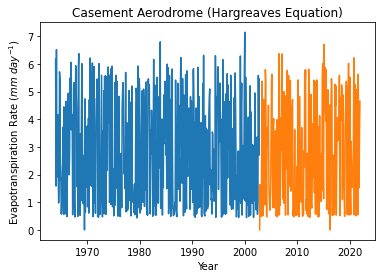

In [280]:
plt.plot(df_1.date[0:len(X_train)], y_train, label="Training Data")
plt.plot(df_1.date[len(X_train):], y_test, label="Testing Data")
plt.title("Casement Aerodrome (Hargreaves Equation)")
plt.ylabel(r"Evapotranspiration Rate ($mm\ day^{-1}$)")
plt.xlabel("Year")
# plt.savefig("../report/images/")

In [281]:
mse

6.959085678894163

#### Thornthwaite equation

In [282]:
y_t = []
latitude = pyeto.deg2rad(53.306)

for i in range(0, len(X), 12):
    mean_monthly_temperature = X.meant[i:i+12]
    monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
    y_t.append(pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight))

# flatten y_t from list of lists
y_t = [item for sublist in y_t for item in sublist]
# yt_std = MinMaxScaler().fit_transform(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_std, y_t, test_size=0.33, random_state=42)

In [283]:
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

y_predicted = nw.predict(X_test)
mse = np.mean((y_predicted - y_test) ** 2)

Text(0.5, 0, 'Year')

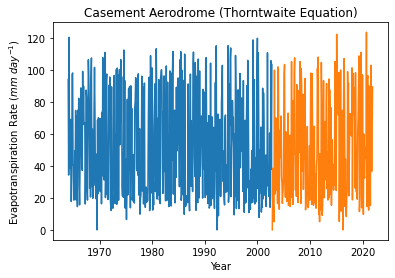

In [285]:
plt.plot(df_1.date[0:len(X_train)], y_train, label="Training Data")
plt.plot(df_1.date[len(X_train):], y_test, label="Testing Data")
plt.title("Casement Aerodrome (Thorntwaite Equation)")
plt.ylabel(r"Evapotranspiration Rate ($mm\ day^{-1}$)")

plt.xlabel("Year")
# plt.savefig("../report/images/")

In [286]:
mse

1998.263360570049

The above cells $\S5.1.1$ \& $\S5.1.2$ are for testing purposes only. The results in both RME and the produced plots are not used in this analysis. They are only there as a method of testing wheter or not the functions used would produce any output.

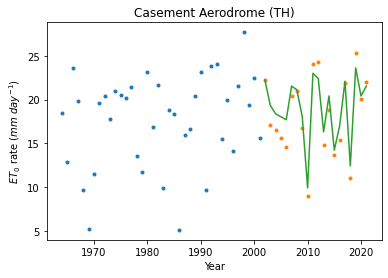

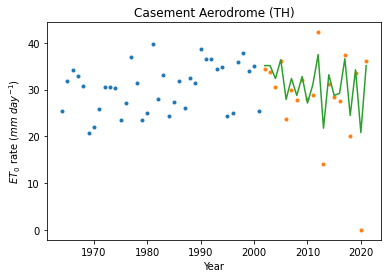

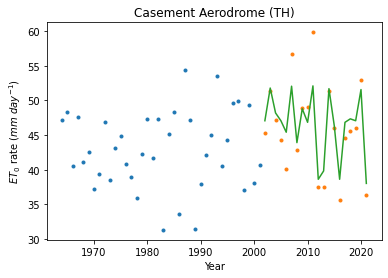

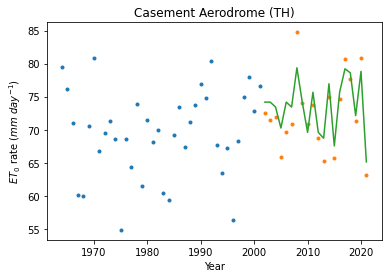

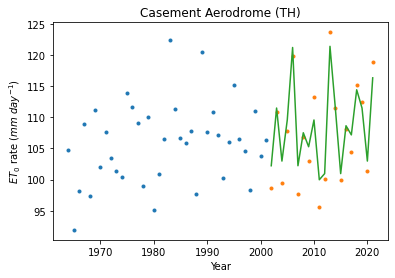

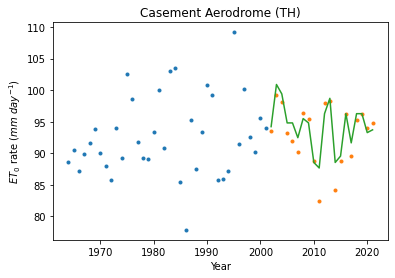

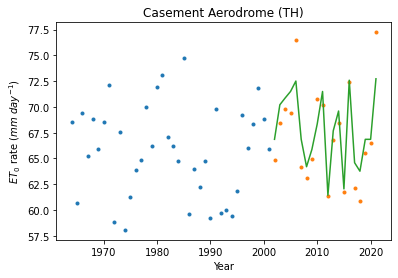

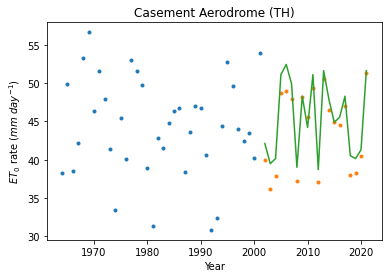

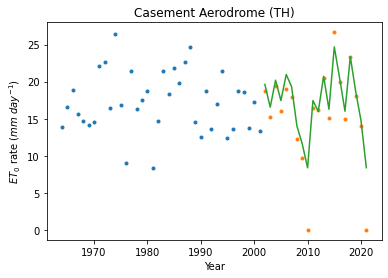

In [163]:
# we'll separate this by month here
X_train = []
X_test = []

y_test = []
y_train = []

y_pred = []
mse = []

for col in X.columns:
    # manual splitting
    X_train.append(CA_meant_std[:38, col-1])
    X_test.append(CA_meant_std[38:, col-1])
    
    y_train.append(list(map(itemgetter(col-1), y_t))[:38])
    y_test.append(list(map(itemgetter(col-1), y_t))[38:])

    nw = algorithms.GRNN(std=0.1, verbose=False)
    nw.train(X_train[col-1], y_train[col-1])

    y_pred.append(nw.predict(X_test[col-1]))
    mse.append(np.mean((y_pred[col-1] - y_test[col-1]) ** 2))
    
    plt.plot(CA_meant.index.values[:38], y_train[col-1], '.', label="Training Data")
    plt.plot(CA_meant.index.values[38:], y_test[col-1], '.', label="Testing Data")
    plt.plot(CA_meant.index.values[38:], y_pred[col-1], label="Prediction")
    plt.title("Casement Aerodrome (TH)")
    plt.xlabel("Year")
    plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")
    plt.show()

The array of years below will be used when generating the csv files of output values later.

In [16]:
yr = np.array([2022, 2023, 2024, 2025])

In [17]:
# set the scaler        
scaler = MinMaxScaler()

### Functions

In [18]:
def ET_rad(latitude, year, month):
    #calculates the day number
    day = datetime.date(year, month, 1).timetuple().tm_yday

    sol_dec = pyeto.sol_dec(day)
    sha = pyeto.sunset_hour_angle(latitude, sol_dec)
    ird = pyeto.inv_rel_dist_earth_sun(day)
    
    return pyeto.et_rad(latitude, sol_dec, sha, ird)

In [141]:
def line(x, m, b):
    return m * x + b

## Casement Aerodrome

In [147]:
# latitude of weather station
lat = pyeto.deg2rad(53.306)

# forecast data
X_CA = pd.read_csv("../Datasets/damo/casement_aerodrome.csv")

X_CA.head()

year  month  day      meant     mintp      maxtp         sun
0  2022      1    1   4.608222 -1.621782  11.001349   50.806112
1  2022      2    1   5.173121 -3.567959  12.413791   68.415069
2  2022      3    1   3.300001 -3.243413  17.389100   76.246556
3  2022      4    1   7.699965 -1.457542  20.080373  130.141632
4  2022      5    1  11.999993  0.993657  22.150759  187.672083

### Casement Aerodrome - Hargreaves equation

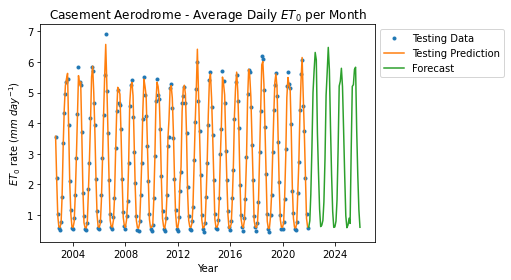

In [47]:
X = []
y_result = []
rmse = []

for i in range(len(df_1)):
    # creating the array of X values
    X.append([
        df_1.mintp[i], 
        df_1.maxtp[i], 
        df_1.meant[i], 
        ET_rad(lat, df_1.year[i], df_1.month[i])
    ])
    
    # daily average evapotranspiration in mm/day
    y_result.append(
        pyeto.hargreaves(
            X[i][0], 
            X[i][1], 
            X[i][2], 
            X[i][3]
        )
    )

# splitting
X_train = scaler.fit_transform(X[:464])
X_test = scaler.fit_transform(X[464:])
    
y_train = scaler.fit_transform(np.array(y_result[:464]).reshape(-1, 1))
y_test = scaler.fit_transform(np.array(y_result[464:]).reshape(-1, 1))

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

X_ET = []

# generate the ET rad values for forecast
for i in range(len(X_CA)):
    X_ET.append(ET_rad(lat, X_CA.year[i], X_CA.month[i]))

X_fore = np.column_stack((
    scaler.fit_transform(np.array(X_CA.mintp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_CA.maxtp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_CA.meant).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_ET).reshape(-1,1))
))

y_fore = nw.predict(X_fore)

# reset the scaler
scaler.fit_transform(np.array(y_result).reshape(-1,1))

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

# plotting
plt.plot(df_1.date[:464], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_CA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Casement Aerodrome - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_1.date[464:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_CA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Casement Aerodrome - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [48]:
rmse

0.16806799739277348

In [42]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[0.59489482, 0.80870175, 1.67718252, 3.19430417, 4.99639097,
        5.72046521, 6.31132358, 6.06966663, 3.68333981, 2.38413744,
        1.18914713, 0.62031457],
       [0.66524312, 0.82099042, 1.4211469 , 2.84507658, 4.90708602,
        5.67016844, 6.4761294 , 5.75114005, 3.8804701 , 2.32324649,
        1.11929535, 0.59391574],
       [0.61009912, 0.79710526, 1.48726503, 3.18162913, 5.21393894,
        5.37210086, 5.79412619, 5.19318865, 3.76273652, 2.30347398,
        0.97569669, 0.58383639],
       [0.66825346, 0.89418215, 0.72350809, 3.13992628, 5.20138692,
        5.25768132, 5.75341827, 5.82856648, 3.77036816, 2.31878727,
        1.17347712, 0.59753219]])

In [39]:
with open("../CA_ET0_HG.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

Text(0, 0.5, '$ET_0$ rate ($mm\\ day^{-1}$)')

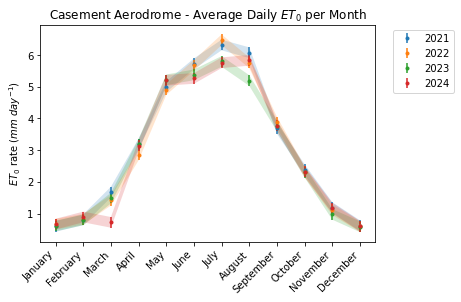

In [45]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Casement Aerodrome - Average Daily $ET_0$ per Month")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

### Casement Aerodrome - Thornthwaite Equation

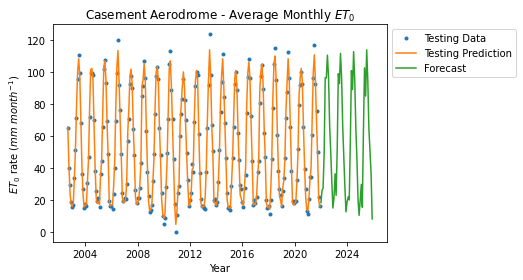

In [148]:
X = []
X_flat = []
y_result = []
latitude = pyeto.deg2rad(53.306)

for i in range(0, len(df_1), 12):
    # gathers the mean monthly temps into yearly groups
    mean_monthly_temperature = df_1.meant[i:i+12].tolist()
    
    # calculates the mean monthly hours off daylight for the year
    monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
    
    X.append(mean_monthly_temperature)
    X.append(monthly_mean_daylight)
    
    # monthly average evapotranspiration in mm/day
    y_result.append(pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight))
    
# convert X from list of lists to 2d array
for i in range(0, len(X), 2):
    for j in range(len(X[0])):
        X_flat.append([X[i][j], X[i+1][j]])

# flatten y_result from list of lists to 1d array
y_result = np.array(y_result).reshape(-1,1)

# splitting
X_train = scaler.fit_transform(np.array(X_flat[:464]))
X_test = scaler.fit_transform(np.array(X_flat[464:]))
    
y_train = scaler.fit_transform(y_result[:464])
y_test = scaler.fit_transform(y_result[464:])

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

MMD = np.array(monthly_mean_daylight*4).reshape(-1, 1)

X_fore = np.column_stack((np.array(X_CA.meant).reshape(-1,1), MMD))
y_fore = nw.predict(scaler.fit_transform(X_fore))

# reset the scaler
scaler.fit_transform(y_result)

# plotting
plt.plot(df_1.date[:464], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_CA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Casement Aerodrome - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_1.date[464:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_1.date[464:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_CA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Casement Aerodrome - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [281]:
rmse

3.3148083055720567

In [405]:
with open("../CA_ET0_TH.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

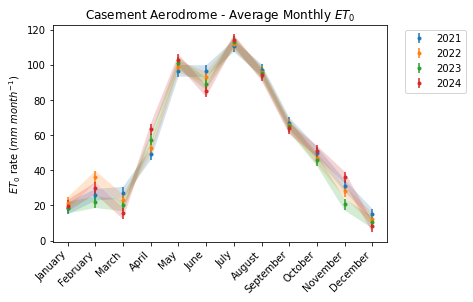

In [301]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Casement Aerodrome - Average Monthly $ET_0$")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)");

### Relationship between inputs and output

Text(0, 0.5, 'Potential Evapotranspiration')

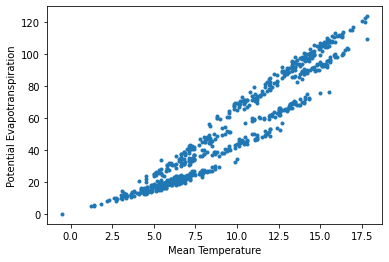

In [149]:
plt.plot(df_1.meant, y_result, '.')
plt.xlabel("Mean Temperature")
plt.ylabel("Potential Evapotranspiration")

Text(0, 0.5, 'Potential Evapotranspiration')

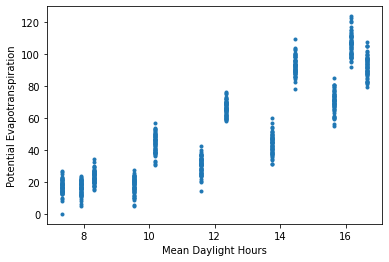

In [150]:
plt.plot(np.array(X_flat)[:,1], y_result, '.')
plt.xlabel("Mean Daylight Hours")
plt.ylabel("Potential Evapotranspiration")

r here is the correlation coefficient. Range is \[+1, -1\] with +1 being perfectly correlated.

In [151]:
# mean temperature vs. potential evapotranspiration
r, p = pearsonr(np.array(df_1.meant).flatten(), np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9578133955722905


In [152]:
# mean daylight hours vs. potential evapotranspiration
r, p = pearsonr(np.array(X_flat)[:,1], np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.8918549323851896


In [153]:
# forecast mean temp. vs. predicted PET
r, p = pearsonr(np.array(X_CA.meant).flatten(), np.array(y_fore).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.8988661949641916


In [154]:
# fitting the data with  straight line
popt, pcov = curve_fit(line, np.array(X_CA.meant).flatten(), np.array(y_fore).flatten())

In [155]:
# covariance matrix
pcov

array([[ 1.37406374e-05, -1.19766135e-04],
       [-1.19766135e-04,  1.36567432e-03]])

In [156]:
# std. deviation
np.sqrt(np.diag(pcov))

array([0.00370684, 0.03695503])

Text(0, 0.5, 'Potential ETo (normalised)')

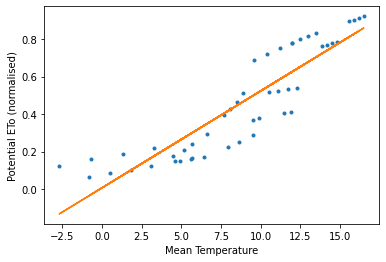

In [157]:
# fit line using the optimised parameters
plt.plot(X_CA.meant, y_fore, '.')
plt.plot(X_CA.meant, line(X_CA.meant, *popt))
plt.xlabel("Mean Temperature")
plt.ylabel("Potential ETo (normalised)")

## Malin Head

In [158]:
# forecast data
X_MH = pd.read_csv("../Datasets/damo/malin_head.csv")

X_MH.head()

year  month  day      meant     mintp      maxtp         sun
0  2022      1    1   5.714217 -4.413985  10.882424   30.317742
1  2022      2    1   6.729982 -1.334928  11.840078   31.813256
2  2022      3    1   7.227041 -1.382813  12.741356   60.149994
3  2022      4    1   8.738210  1.432259  17.896437  123.503675
4  2022      5    1  11.053838  4.869148  18.462372  143.707205

### Malin Head - Hargreaves Equation

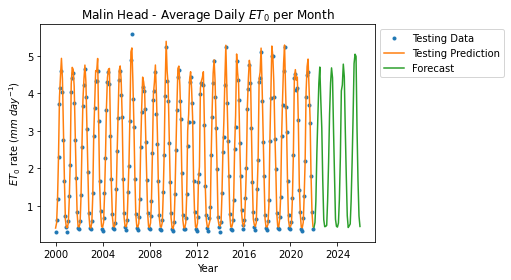

In [23]:
X = []
y_result = []
lat = pyeto.deg2rad(55.372)

for i in range(len(df_2)):
    # creating the array of X values
    X.append([
        df_2.mintp[i], 
        df_2.maxtp[i], 
        df_2.meant[i], 
        ET_rad(lat, df_2.year[i], df_2.month[i])
    ])
    
    # daily average evapotranspiration in mm/day
    y_result.append(
        pyeto.hargreaves(
            X[i][0], 
            X[i][1], 
            X[i][2], 
            X[i][3]
        )
    )

# splitting
X_train = scaler.fit_transform(X[:528])
X_test = scaler.fit_transform(X[528:])
    
y_train = scaler.fit_transform(np.array(y_result[:528]).reshape(-1, 1))
y_test = scaler.fit_transform(np.array(y_result[528:]).reshape(-1, 1))

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

X_ET = []

# generate the ET rad values for forecast
for i in range(len(X_MH)):
    X_ET.append(ET_rad(lat, X_MH.year[i], X_MH.month[i]))

X_fore = np.column_stack((
    scaler.fit_transform(np.array(X_MH.mintp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_MH.maxtp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_MH.meant).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_ET).reshape(-1,1))
))

y_fore = nw.predict(X_fore)

# reset the scaler
scaler.fit_transform(np.array(y_result).reshape(-1,1))

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

# plotting
plt.plot(df_2.date[:528], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_MH[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_2.date[528:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_MH[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [24]:
rmse

0.1766930026740168

In [25]:
error_array = np.array([rmse]*7)
print(error_array.reshape(1,-1))
scaler.inverse_transform(error_array.reshape(1,-1))

[[0.176693 0.176693 0.176693 0.176693 0.176693 0.176693 0.176693]]


array([[1.2416448, 1.2416448, 1.2416448, 1.2416448, 1.2416448, 1.2416448,
        1.2416448]])

In [26]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[0.43355326, 0.5650405 , 1.13150688, 2.41585228, 3.35358463,
        4.26147071, 4.69939853, 3.83019829, 3.07413466, 1.68342304,
        0.63762778, 0.452173  ],
       [0.45893354, 0.48822796, 1.14093168, 2.18008326, 3.4502924 ,
        4.27427665, 4.6769843 , 4.41170096, 3.02782231, 1.84001515,
        0.64917724, 0.4601235 ],
       [0.44054557, 0.5512916 , 1.17930843, 2.31139327, 4.06589984,
        4.22024837, 4.77672929, 4.44211085, 3.02163477, 1.82001779,
        0.74169506, 0.42927435],
       [0.47272941, 0.52399939, 1.12641482, 2.16158307, 3.36406409,
        4.79120769, 5.04125363, 4.98477275, 3.04053635, 1.67810796,
        0.73666742, 0.45743757]])

In [413]:
with open("../MH_ET0_HG.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

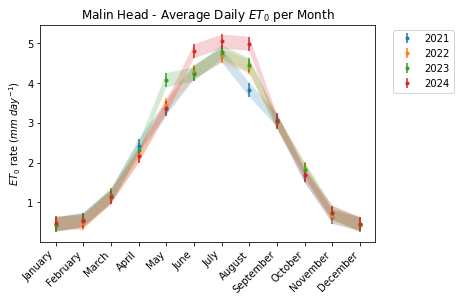

In [27]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Malin Head - Average Daily $ET_0$ per Month")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)");

### Malin Head - Thornthwaite Equation

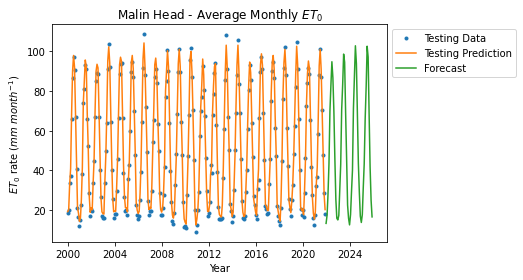

In [159]:
X = []
X_flat = []
y_result = []
latitude = pyeto.deg2rad(53.306)

for i in range(0, len(df_2), 12):
    # gathers the mean monthly temps into yearly groups
    mean_monthly_temperature = df_2.meant[i:i+12].tolist()
    
    # calculates the mean monthly hours off daylight for the year
    monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
    
    X.append(mean_monthly_temperature)
    X.append(monthly_mean_daylight)
    
    # monthly average evapotranspiration in mm/day
    y_result.append(pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight))
    
# convert X from list of lists to 2d array
for i in range(0, len(X), 2):
    for j in range(len(X[0])):
        X_flat.append([X[i][j], X[i+1][j]])

# flatten y_result from list of lists to 1d array
y_result = np.array(y_result).reshape(-1,1)

# splitting
X_train = scaler.fit_transform(np.array(X_flat[:528]))
X_test = scaler.fit_transform(np.array(X_flat[528:]))
    
y_train = scaler.fit_transform(y_result[:528])
y_test = scaler.fit_transform(y_result[528:])

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

MMD = np.array(monthly_mean_daylight*4).reshape(-1, 1)

X_fore = np.column_stack((np.array(X_MH.meant).reshape(-1,1), MMD))
y_fore = nw.predict(scaler.fit_transform(X_fore))

# reset the scaler
scaler.fit_transform(y_result)

# plotting
plt.plot(df_2.date[:528], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_MH[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_2.date[528:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_2.date[528:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_MH[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [29]:
rmse

2.7910340122082102

In [30]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[ 13.35898111,  17.4360505 ,  27.63050398,  43.40838089,
         69.96627829,  83.27453108,  94.76972659,  86.63499517,
         69.61934122,  46.1626718 ,  25.43904186,  15.93862764],
       [ 15.10567505,  17.36920421,  29.49770607,  43.08481145,
         70.59814441,  83.1821495 ,  98.61966055,  94.54400742,
         69.01825143,  46.57556993,  22.5875522 ,  15.94637301],
       [ 12.59594153,  17.79020024,  29.00174572,  40.16490589,
         71.29734953,  87.76595895, 102.81026487,  93.79796955,
         68.49355342,  43.71339279,  28.72257237,  17.0164781 ],
       [ 13.81295177,  17.80425604,  30.71378999,  43.40701703,
         66.07488128,  82.36263429, 102.58590401,  97.14977728,
         67.905889  ,  41.85435332,  24.99717782,  16.62673514]])

In [417]:
with open("../MH_ET0_TH.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

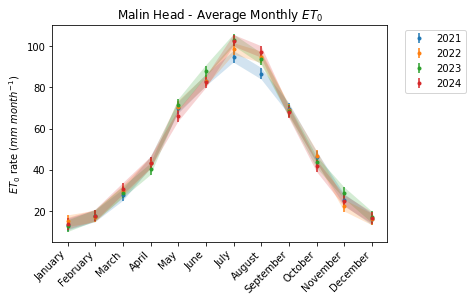

In [32]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Malin Head - Average Monthly $ET_0$")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)");

### Relationship between inputs and output

Text(0, 0.5, 'Potential Evapotranspiration')

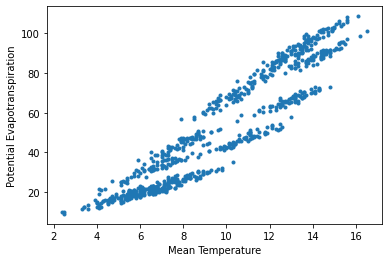

In [160]:
plt.plot(df_2.meant, y_result, '.')
plt.xlabel("Mean Temperature")
plt.ylabel("Potential Evapotranspiration")

Text(0, 0.5, 'Potential Evapotranspiration')

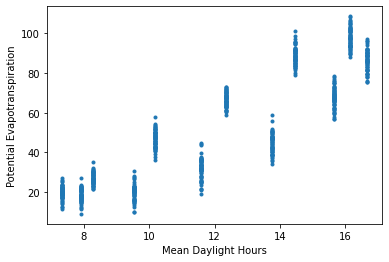

In [161]:
plt.plot(np.array(X_flat)[:,1], y_result, '.')
plt.xlabel("Mean Daylight Hours")
plt.ylabel("Potential Evapotranspiration")

r here is the correlation coefficient. Range is \[+1, -1\] with +1 being perfectly correlated.

In [162]:
# mean temperature vs. potential evapotranspiration
r, p = pearsonr(np.array(df_2.meant).flatten(), np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9375631259484494


In [163]:
# mean daylight hours vs. potential evapotranspiration
r, p = pearsonr(np.array(X_flat)[:,1], np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.8892534733808258


In [164]:
# forecast mean temp. vs. predicted PET
r, p = pearsonr(np.array(X_MH.meant).flatten(), np.array(y_fore).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9412250995256071


In [165]:
# fitting the data with  straight line
popt, pcov = curve_fit(line, np.array(X_MH.meant).flatten(), np.array(y_fore).flatten())

In [166]:
# covariance matrix
pcov

array([[ 2.48444512e-05, -2.50887609e-04],
       [-2.50887609e-04,  2.76046843e-03]])

In [167]:
# std. deviation
np.sqrt(np.diag(pcov))

array([0.00498442, 0.05254016])

Text(0, 0.5, 'Potential ETo (normalised)')

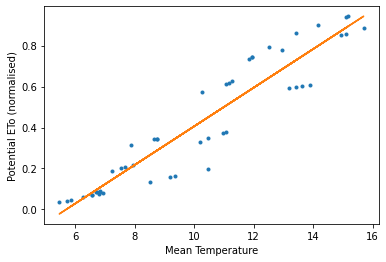

In [168]:
# fit line using the optimised parameters
plt.plot(X_MH.meant, y_fore, '.')
plt.plot(X_MH.meant, line(X_MH.meant, *popt))
plt.xlabel("Mean Temperature")
plt.ylabel("Potential ETo (normalised)")

## Valentia

In [169]:
# forecast data
X_VA = pd.read_csv("../Datasets/damo/valentia.csv")

X_VA.head()

year  month  day      meant     mintp      maxtp         sun
0  2022      1    1   7.702808  0.801945  12.475563   31.991240
1  2022      2    1   5.974382 -1.260533  12.009556   60.012362
2  2022      3    1   8.215716 -1.931839  14.444583  108.764237
3  2022      4    1   8.799599  2.445115   3.826038  133.884156
4  2022      5    1  11.227826  4.362947  21.242382  174.622334

### Valentia - Hargreaves Equation

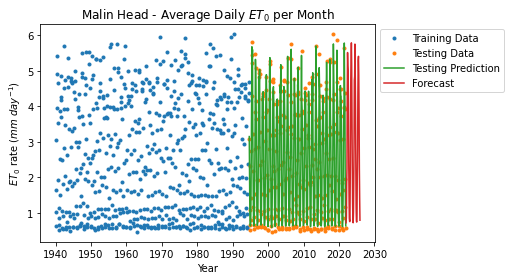

In [67]:
X = []
y_result = []
lat = pyeto.deg2rad(51.938)

for i in range(len(df_3)):
    # creating the array of X values
    X.append([
        df_3.mintp[i], 
        df_3.maxtp[i], 
        df_3.meant[i], 
        ET_rad(lat, df_3.year[i], df_3.month[i])
    ])
    
    # daily average evapotranspiration in mm/day
    y_result.append(
        pyeto.hargreaves(
            X[i][0], 
            X[i][1], 
            X[i][2], 
            X[i][3]
        )
    )

# splitting
X_train = scaler.fit_transform(X[:656])
X_test = scaler.fit_transform(X[656:])
    
y_train = scaler.fit_transform(np.array(y_result[:656]).reshape(-1, 1))
y_test = scaler.fit_transform(np.array(y_result[656:]).reshape(-1, 1))

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

X_ET = []

# generate the ET rad values for forecast
for i in range(len(X_VA)):
    X_ET.append(ET_rad(lat, X_VA.year[i], X_VA.month[i]))

X_fore = np.column_stack((
    scaler.fit_transform(np.array(X_VA.mintp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_VA.maxtp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_VA.meant).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_ET).reshape(-1,1))
))

y_fore = nw.predict(X_fore)

# reset the scaler
scaler.fit_transform(np.array(y_result).reshape(-1,1))

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

# plotting
plt.plot(df_3.date[:656], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_VA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_3.date[656:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_VA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Malin Head - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [68]:
rmse

0.12959363347083772

In [69]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[0.72224144, 0.87645841, 1.7749466 , 2.24725336, 4.39176009,
        5.51017721, 5.13894541, 4.96998821, 4.11281342, 2.41287951,
        1.51485415, 0.8452642 ],
       [0.75751396, 0.75430438, 1.75309123, 3.1033685 , 4.78157961,
        5.30644385, 5.78248465, 5.18483605, 3.76574404, 2.36537632,
        1.32418799, 0.82650958],
       [0.72224639, 1.01577007, 1.83758452, 2.91065689, 4.73657344,
        4.83752987, 5.74813166, 4.98327441, 3.87101987, 2.31952077,
        1.1561184 , 0.77341091],
       [0.74110598, 0.97927701, 2.00830614, 2.77894821, 4.31213604,
        5.28727992, 5.40405494, 4.87070511, 3.85754148, 2.26082941,
        1.41091377, 0.79336677]])

In [423]:
with open("../VA_ET0_HG.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

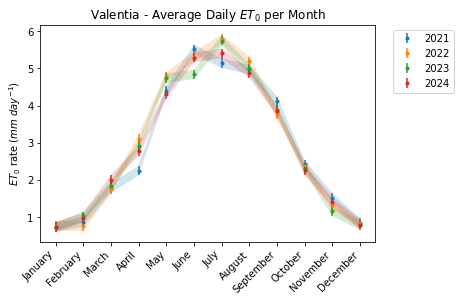

In [70]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Valentia - Average Daily $ET_0$ per Month")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)");

### Valentia - Thornthwaite Equation

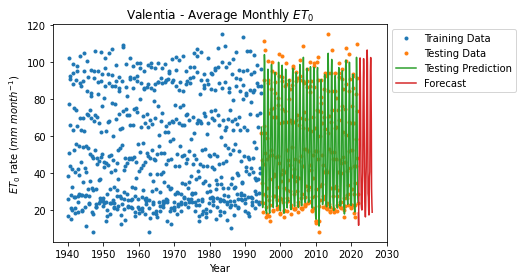

In [170]:
X = []
X_flat = []
y_result = []
latitude = lat

for i in range(0, len(df_3), 12):
    # gathers the mean monthly temps into yearly groups
    mean_monthly_temperature = df_3.meant[i:i+12].tolist()
    
    # calculates the mean monthly hours off daylight for the year
    monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
    
    X.append(mean_monthly_temperature)
    X.append(monthly_mean_daylight)
    
    # monthly average evapotranspiration in mm/day
    y_result.append(pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight))
    
# convert X from list of lists to 2d array
for i in range(0, len(X), 2):
    for j in range(len(X[0])):
        X_flat.append([X[i][j], X[i+1][j]])

# flatten y_result from list of lists to 1d array
y_result = np.array(y_result).reshape(-1,1)

# splitting
X_train = scaler.fit_transform(np.array(X_flat[:656]))
X_test = scaler.fit_transform(np.array(X_flat[656:]))
    
y_train = scaler.fit_transform(y_result[:656])
y_test = scaler.fit_transform(y_result[656:])

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

MMD = np.array(monthly_mean_daylight*4).reshape(-1, 1)

X_fore = np.column_stack((np.array(X_VA.meant).reshape(-1,1), MMD))
y_fore = nw.predict(scaler.fit_transform(X_fore))

# reset the scaler
scaler.fit_transform(y_result)

# plotting
plt.plot(df_3.date[:656], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_VA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Valentia - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_3.date[656:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_3.date[656:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_VA[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Valentia - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [72]:
rmse

2.492269087556126

In [44]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[ 18.25008229,  11.5619433 ,  31.02656417,  42.32570477,
         69.18347119,  94.98704907, 102.29880929,  91.82614055,
         69.14412338,  42.65224876,  22.75560824,  20.67915809],
       [ 19.84974996,  21.91753617,  34.02532215,  40.02980579,
         72.28053303,  90.42623153, 101.90749041,  94.40544999,
         64.68887624,  46.89624582,  24.40773521,  20.18345761],
       [ 16.11079144,  22.4342321 ,  36.73564294,  43.24719382,
         69.49173244,  89.46798453, 106.6029468 ,  99.75481982,
         66.68999553,  28.79575743,  26.96062865,  19.9949565 ],
       [ 17.14420869,  25.195763  ,  37.89208707,  40.53344168,
         69.70327471,  94.93876115, 102.51138725,  91.09815304,
         69.21921662,  31.43154811,  23.59151018,  18.65573091]])

In [427]:
with open("../VA_ET0_TH.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

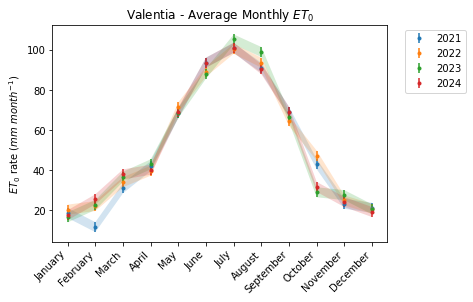

In [73]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Valentia - Average Monthly $ET_0$")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)");

### Relationship between inputs and output

Text(0, 0.5, 'Potential Evapotranspiration')

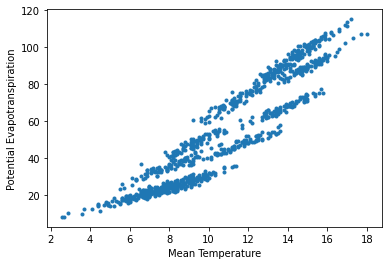

In [171]:
plt.plot(df_3.meant, y_result, '.')
plt.xlabel("Mean Temperature")
plt.ylabel("Potential Evapotranspiration")

Text(0, 0.5, 'Potential Evapotranspiration')

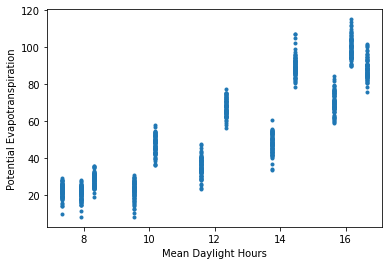

In [172]:
plt.plot(np.array(X_flat)[:,1], y_result, '.')
plt.xlabel("Mean Daylight Hours")
plt.ylabel("Potential Evapotranspiration")

r here is the correlation coefficient. Range is \[+1, -1\] with +1 being perfectly correlated.

In [173]:
# mean temperature vs. potential evapotranspiration
r, p = pearsonr(np.array(df_3.meant).flatten(), np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9319066194083971


In [174]:
# mean daylight hours vs. potential evapotranspiration
r, p = pearsonr(np.array(X_flat)[:,1], np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.8967556514870961


In [175]:
# forecast mean temp. vs. predicted PET
r, p = pearsonr(np.array(X_VA.meant).flatten(), np.array(y_fore).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9489329008517442


In [176]:
# fitting the data with  straight line
popt, pcov = curve_fit(line, np.array(X_VA.meant).flatten(), np.array(y_fore).flatten())

In [177]:
# covariance matrix
pcov

array([[ 2.37275616e-05, -2.58358030e-04],
       [-2.58358030e-04,  2.99103883e-03]])

In [178]:
# std. deviation
np.sqrt(np.diag(pcov))

array([0.00487109, 0.05469039])

Text(0, 0.5, 'Potential ETo (normalised)')

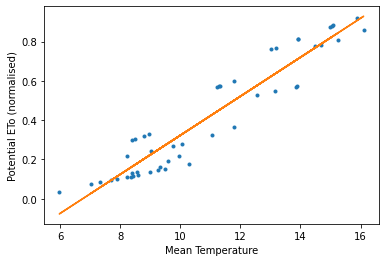

In [179]:
# fit line using the optimised parameters
plt.plot(X_VA.meant, y_fore, '.')
plt.plot(X_VA.meant, line(X_VA.meant, *popt))
plt.xlabel("Mean Temperature")
plt.ylabel("Potential ETo (normalised)")

## Belmullet

In [58]:
# latitude
lat = pyeto.deg2rad(54.228)

# forecast data
X_BM = pd.read_csv("../Datasets/damo/belmullet.csv")

X_BM.head()

year  month  day      meant     mintp      maxtp         sun
0  2022      1    1   7.566505 -0.030515  11.976793   25.931580
1  2022      2    1   7.807198 -1.667738  11.748182   55.490364
2  2022      3    1   7.996338 -1.061081  12.706377   67.846520
3  2022      4    1   9.870114  1.646168  14.867440  133.277075
4  2022      5    1  11.647319  3.146418  23.222714  149.250489

### Belmullet - Hargreaves Equation

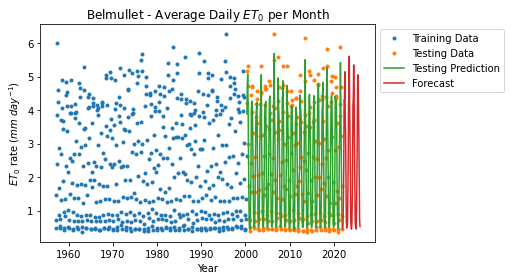

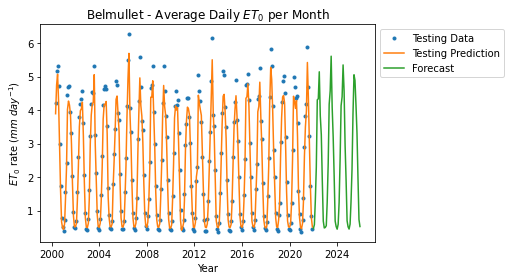

In [59]:
X = []
y_result = []

for i in range(len(df_4)):
    # creating the array of X values
    X.append([
        df_4.mintp[i], 
        df_4.maxtp[i], 
        df_4.meant[i], 
        ET_rad(lat, df_4.year[i], df_4.month[i])
    ])
    
    # daily average evapotranspiration in mm/day
    y_result.append(
        pyeto.hargreaves(
            X[i][0], 
            X[i][1], 
            X[i][2], 
            X[i][3]
        )
    )

# splitting
X_train = scaler.fit_transform(X[:520])
X_test = scaler.fit_transform(X[520:])
    
y_train = scaler.fit_transform(np.array(y_result[:520]).reshape(-1, 1))
y_test = scaler.fit_transform(np.array(y_result[520:]).reshape(-1, 1))

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

X_ET = []

# generate the ET rad values for forecast
for i in range(len(X_BM)):
    X_ET.append(ET_rad(lat, X_BM.year[i], X_BM.month[i]))

X_fore = np.column_stack((
    scaler.fit_transform(np.array(X_BM.mintp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_BM.maxtp).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_BM.meant).reshape(-1,1)), 
    scaler.fit_transform(np.array(X_ET).reshape(-1,1))
))

y_fore = nw.predict(X_fore)

# reset the scaler
scaler.fit_transform(np.array(y_result).reshape(-1,1))

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

# plotting
plt.plot(df_4.date[:520], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_BM[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Belmullet - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_4.date[520:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_BM[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Belmullet - Average Daily $ET_0$ per Month")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [60]:
rmse

0.26256022810592433

In [61]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[0.46368309, 0.58175582, 1.2771935 , 2.30207487, 4.30819009,
        4.33829183, 5.14370223, 3.82898914, 3.27028762, 1.92704081,
        0.68820961, 0.48254535],
       [0.4974398 , 0.55130894, 1.24494788, 2.41272547, 4.17304466,
        4.57239603, 5.60923866, 4.08389066, 3.19540745, 2.03331882,
        0.68871929, 0.52602763],
       [0.44672025, 0.59309016, 1.24045302, 2.55539199, 4.13456389,
        4.39783512, 5.34881874, 4.56705779, 2.93593467, 1.91878255,
        0.6968365 , 0.51790517],
       [0.44956376, 0.59808561, 1.24791396, 2.22193557, 3.88080868,
        5.05446368, 4.88805772, 4.14864764, 3.31282442, 1.98874679,
        0.73352501, 0.52520956]])

In [435]:
with open("../BM_ET0_HG.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

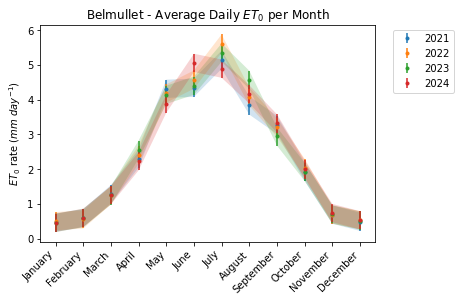

In [62]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Belmullet - Average Daily $ET_0$ per Month")
plt.ylabel(r"$ET_0$ rate ($mm\ day^{-1}$)");

### Belmullet - Thornthwaite Equation

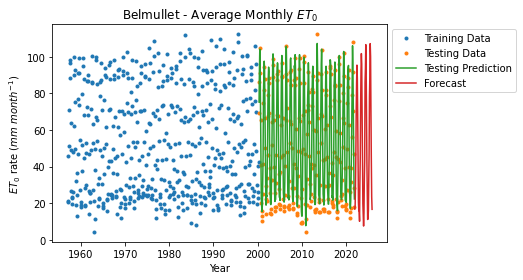

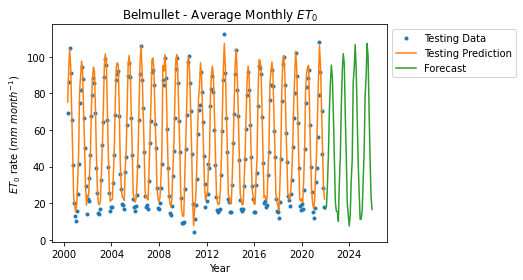

In [81]:
X = []
X_flat = []
y_result = []
latitude = lat

for i in range(0, len(df_4), 12):
    # gathers the mean monthly temps into yearly groups
    mean_monthly_temperature = df_4.meant[i:i+12].tolist()
    
    # calculates the mean monthly hours off daylight for the year
    monthly_mean_daylight = pyeto.monthly_mean_daylight_hours(latitude)
    
    X.append(mean_monthly_temperature)
    X.append(monthly_mean_daylight)
    
    # monthly average evapotranspiration in mm/day
    y_result.append(pyeto.thornthwaite(mean_monthly_temperature, monthly_mean_daylight))
    
# convert X from list of lists to 2d array
for i in range(0, len(X), 2):
    for j in range(len(X[0])):
        X_flat.append([X[i][j], X[i+1][j]])

# flatten y_result from list of lists to 1d array
y_result = np.array(y_result).reshape(-1,1)

# splitting
X_train = scaler.fit_transform(np.array(X_flat[:520]))
X_test = scaler.fit_transform(np.array(X_flat[520:]))
    
y_train = scaler.fit_transform(y_result[:520])
y_test = scaler.fit_transform(y_result[520:])

# initialise the network
nw = algorithms.GRNN(std=0.1, verbose=False)
nw.train(X_train, y_train)

# predictions
y_pred = nw.predict(X_test)

# error
rmse = estimators.rmse(scaler.inverse_transform(y_pred), scaler.inverse_transform(y_test))

MMD = np.array(monthly_mean_daylight*4).reshape(-1, 1)

X_fore = np.column_stack((np.array(X_BM.meant).reshape(-1,1), MMD))
y_fore = nw.predict(scaler.fit_transform(X_fore))

# reset the scaler
scaler.fit_transform(y_result)

# plotting
plt.plot(df_4.date[:520], scaler.inverse_transform(y_train), '.', label='Training Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_BM[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Belmullet - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# area of interest
plt.plot(df_4.date[520:], scaler.inverse_transform(y_test), '.', label='Testing Data')
plt.plot(df_4.date[520:], scaler.inverse_transform(y_pred), label='Testing Prediction')
plt.plot(pd.to_datetime(X_BM[['year', 'month', 'day']]), scaler.inverse_transform(y_fore), label='Forecast')

plt.title(r"Belmullet - Average Monthly $ET_0$")
plt.xlabel("Year")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)")

plt.legend(bbox_to_anchor=(1,1))

In [64]:
rmse

4.660270509090874

In [65]:
np.array(scaler.inverse_transform(y_fore)).reshape(4,12)

array([[ 16.05792939,  18.17593037,  29.62387665,  46.77271989,
         72.27078394,  87.98675452,  97.79429752,  89.67518476,
         68.1556269 ,  43.21850873,  19.64022938,  14.91363361],
       [ 14.70229453,   9.93393108,  30.63404613,  45.19941587,
         74.08624976,  94.59927909, 104.17287349,  97.46232977,
         68.46490534,  45.25189875,  19.05263927,  13.01291197],
       [  7.22731401,  14.23415955,  32.19201775,  43.89766614,
         87.89134552,  95.85097783, 109.15289896,  94.72625798,
         66.93609727,  41.47965012,  24.28248367,  10.6104827 ],
       [ 10.90062343,  15.70595642,  31.4427789 ,  47.84509829,
         79.96252974,  91.2362049 , 109.70952199, 101.473721  ,
         70.04703139,  43.64206767,  22.49652993,  15.84488345]])

In [439]:
with open("../BM_ET0_TH.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows([month])
    csvWriter.writerows(np.c_[yr,np.array(scaler.inverse_transform(y_fore)).reshape(4,12)])

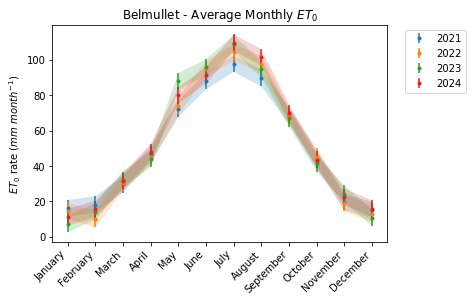

In [66]:
for i in range(4):
    y = np.array(scaler.inverse_transform(y_fore)).reshape(4,12)[i]
    plt.errorbar(month, y, yerr=rmse, fmt='.', label=str(2021+i))
    plt.fill_between(month, y-rmse, y+rmse, alpha=0.2)
             
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation=45, ha="right");
plt.title(r"Belmullet - Average Monthly $ET_0$")
plt.ylabel(r"$ET_0$ rate ($mm\ month^{-1}$)");

### Relationship between inputs and output

Text(0, 0.5, 'Potential Evapotranspiration')

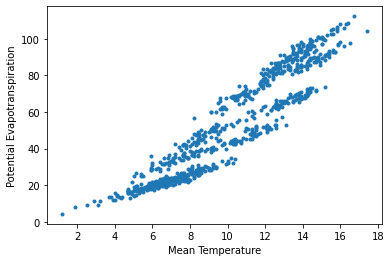

In [142]:
plt.plot(df_4.meant, y_result, '.')
plt.xlabel("Mean Temperature")
plt.ylabel("Potential Evapotranspiration")

Text(0, 0.5, 'Potential Evapotranspiration')

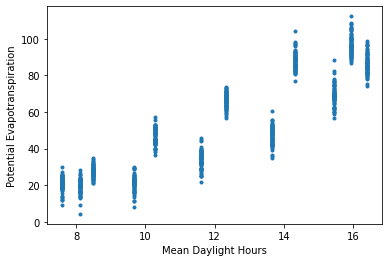

In [143]:
plt.plot(np.array(X_flat)[:,1], y_result, '.')
plt.xlabel("Mean Daylight Hours")
plt.ylabel("Potential Evapotranspiration")

r here is the correlation coefficient. Range is \[+1, -1\] with +1 being perfectly correlated.

In [128]:
# mean temperature vs. potential evapotranspiration
r, p = pearsonr(np.array(df_4.meant).flatten(), np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9399041368541218


In [129]:
# mean daylight hours vs. potential evapotranspiration
r, p = pearsonr(np.array(X_flat)[:,1], np.array(y_result).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.8976156454792047


In [131]:
# forecast mean temp. vs. predicted PET
r, p = pearsonr(np.array(X_BM.meant).flatten(), np.array(y_fore).flatten())
print("Correlation Coefficient: ", r)

Correlation Coefficient:  0.9647903374935394


In [136]:
# fitting the data with  straight line
popt, pcov = curve_fit(line, np.array(X_BM.meant).flatten(), np.array(y_fore).flatten())

In [137]:
# covariance matrix
pcov

array([[ 1.37696805e-05, -1.48142797e-04],
       [-1.48142797e-04,  1.72929407e-03]])

In [139]:
# std. deviation
np.sqrt(np.diag(pcov))

array([0.00371075, 0.04158478])

Text(0, 0.5, 'Potential ETo (normalised)')

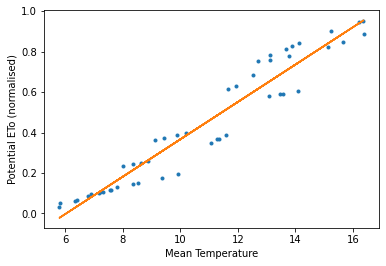

In [145]:
# fit line using the optimised parameters
plt.plot(X_BM.meant, y_fore, '.')
plt.plot(X_BM.meant, line(X_BM.meant, *popt))
plt.xlabel("Mean Temperature")
plt.ylabel("Potential ETo (normalised)")